In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

In [50]:
import torch
import torch.nn.functional as F
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool

## Read Config file

In [3]:
config_path = "/home/yy/deeplearning/deeplearning/mypackages/second/configs/car.lite.nb.config"
config_path = "/home/gx/GitHub/depconv/second/configs/car.fhd.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.eval_input_reader
model_cfg = config.model.second
# config_tool.change_detection_range(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")



In [4]:
input_cfg

batch_size: 1
dataset {
  kitti_info_path: "/home/gx/GitHub/second.pytorch/dataset/kitti_infos_val.pkl"
  kitti_root_path: "/home/gx/GitHub/second.pytorch/dataset/"
  dataset_class_name: "KittiDataset"
}
preprocess {
  max_number_of_voxels: 40000
  num_workers: 4
  anchor_area_threshold: -1.0
}

## Build Network, Target Assigner and Voxel Generator

In [6]:
ckpt_path = "/home/gx/GitHub/depconv/second/depconv19/voxelnet-2320.tckpt"
net = build_network(model_cfg).to(device).eval()
net.load_state_dict(torch.load(ckpt_path))
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator

rpn debug, final_num_filters =  128
rpn debug, num_cls =  2
rpn debug, num_anchor_per_loc =  2


## Generate Anchors

In [7]:
grid_size = voxel_generator.grid_size
feature_map_size = grid_size[:2] // config_tool.get_downsample_factor(model_cfg)
feature_map_size = [*feature_map_size, 1][::-1]

anchors = target_assigner.generate_anchors(feature_map_size)["anchors"]
anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
anchors = anchors.view(1, -1, 7)

feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)


## Read KITTI infos
you can load your custom point cloud.

In [8]:
info_path = input_cfg.dataset.kitti_info_path
root_path = Path(input_cfg.dataset.kitti_root_path)
with open(info_path, 'rb') as f:
    infos = pickle.load(f)

## Load Point Cloud, Generate Voxels

In [9]:
info = infos[564]
v_path = info["point_cloud"]['velodyne_path']
v_path = str(root_path / v_path)
points = np.fromfile(
    v_path, dtype=np.float32, count=-1).reshape([-1, 4])
# voxels, coords, num_points = voxel_generator.generate(points, max_voxels=90000)
# print(voxels.shape)
# add batch idx to coords
# coords = np.pad(coords, ((0, 0), (1, 0)), mode='constant', constant_values=0)
# voxels = torch.tensor(voxels, dtype=torch.float32, device=device)
# coords = torch.tensor(coords, dtype=torch.int32, device=device)
# num_points = torch.tensor(num_points, dtype=torch.int32, device=device)

In [10]:
from second.pytorch.builder import (box_coder_builder, input_reader_builder,
                                    lr_scheduler_builder, optimizer_builder,
                                    second_builder)

# net = build_network(model_cfg, False).to(device)
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator

dataset = input_reader_builder.build(
    input_cfg,
    model_cfg,
    training=False,
    voxel_generator=voxel_generator,
    target_assigner=target_assigner,
    multi_gpu=False)
from second.data.preprocess import merge_second_batch, merge_second_batch_multigpu
from second.pytorch.train import _worker_init_fn
num_gpu=1
collate_fn= merge_second_batch
multi_gpu = False
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=input_cfg.batch_size * num_gpu,
        shuffle=True,
#         num_workers=input_cfg.preprocess.num_workers * num_gpu,
        num_workers=1,
        pin_memory=False,
        collate_fn=collate_fn,
        worker_init_fn=_worker_init_fn,
        drop_last=not multi_gpu)

feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)
feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)
remain number of infos: 3769


## Detection

In [11]:
# example = {
#     "anchors": anchors,
#     "voxels": voxels,
#     "num_points": num_points,
#     "coordinates": coords,
# }
# pred = net(example)[0]
examples = []
loop_i = 0
for example in dataloader:
    loop_i += 1
    if loop_i > 10:
        break
    examples.append(example)
#     print(example)




WORKER 0 seed: 1588867672


In [12]:
examples[0]['voxels'].shape

(8994, 5, 4)

In [13]:
from second.pytorch.train import example_convert_to_torch


example = examples[3]
example = example_convert_to_torch(example)
pred = net(example)

/home/gx/GitHub/depconv/second/pytorch/models/voxelnet.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(feature, device="cuda", dtype=torch.float32)


D_min, D_max=  tensor(0, device='cuda:0') tensor(63, device='cuda:0')
shape BCDHW,  1 64 64 2 64


In [14]:
example = examples[0]
example = example_convert_to_torch(example, torch.float32)

with torch.no_grad():
    pred = net(example)


D_min, D_max=  tensor(0, device='cuda:0') tensor(63, device='cuda:0')
shape BCDHW,  1 64 64 2 64


In [15]:
pred

[{'box3d_lidar': tensor([], device='cuda:0', size=(0, 7)),
  'scores': tensor([], device='cuda:0'),
  'label_preds': tensor([], device='cuda:0', dtype=torch.int64),
  'metadata': {'image_idx': 4697,
   'image_shape': array([ 375, 1242], dtype=int32)}}]

In [16]:
boxes = example['anchors']
boxes
boxes.shape


torch.Size([1, 8192, 7])

In [17]:
boxes[0][1]

tensor([ 0.7857, -0.7857, -1.0000,  1.6000,  3.9000,  1.5600,  0.0000],
       device='cuda:0')

In [18]:
points

array([[74.774,  5.575,  2.745,  0.   ],
       [74.623,  5.799,  2.74 ,  0.   ],
       [74.751,  5.927,  2.745,  0.   ],
       ...,
       [ 3.75 , -1.418, -1.753,  0.21 ],
       [ 3.756, -1.407, -1.754,  0.33 ],
       [ 3.772, -1.4  , -1.76 ,  0.   ]], dtype=float32)

In [19]:
points.shape

(120584, 4)

In [20]:
example["points"][0].shape

(4,)

## Simple Vis

In [24]:
# %config InlineBackend.figure_format = 'retina'


boxes_lidar = boxes.detach().cpu().numpy()
vis_voxel_size = [0.1, 0.1, 0.1]
# vis_point_range = [-50, -30, -3, 50, 30, 1]
vis_point_range = [0, -40, -3, 80, 40, 1]
bev_map = simplevis.point_to_vis_bev(example["points"], vis_voxel_size, vis_point_range)
# bev_map = simplevis.draw_box_in_bev(bev_map, vis_point_range, boxes_lidar, [0, 255, 0], 2)
# bev_map = simplevis.draw_box_in_bev(bev_map,vis_point_range, boxes_lidar[0][0:8000:80,:].cpu().numpy(), [0,255,0], 2)

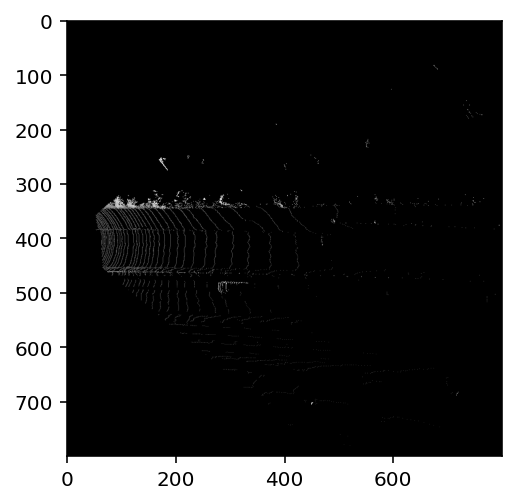

In [25]:
plt.imshow(bev_map)



In [26]:
bev_map = simplevis.kitti_vis(example["points"][0], boxes[0].cpu().numpy())

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of Function(<built-in function getitem>) with argument(s) of type(s): (array(float32, 1d, C), UniTuple(int64 x 2))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
In definition 2:
    All templates rejected with literals.
In definition 3:
    All templates rejected without literals.
In definition 4:
    All templates rejected with literals.
In definition 5:
    All templates rejected without literals.
In definition 6:
    All templates rejected with literals.
In definition 7:
    All templates rejected without literals.
In definition 8:
    All templates rejected with literals.
In definition 9:
    All templates rejected without literals.
In definition 10:
    All templates rejected with literals.
In definition 11:
    All templates rejected without literals.
In definition 12:
    TypeError: cannot index array(float32, 1d, C) with 2 indices: UniTuple(int64 x 2)
    raised from /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/numba/core/typing/arraydecl.py:85
In definition 13:
    TypeError: cannot index array(float32, 1d, C) with 2 indices: UniTuple(int64 x 2)
    raised from /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/numba/core/typing/arraydecl.py:85
In definition 14:
    All templates rejected with literals.
In definition 15:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: typing of intrinsic-call at /home/gx/GitHub/depconv/second/utils/simplevis.py (37)

File "utils/simplevis.py", line 37:
def _points_to_bevmap_reverse_kernel(
    <source elided>
        for j in range(ndim):
            c = np.floor((points[i, j] - coors_range[j]) / voxel_size[j])
            ^


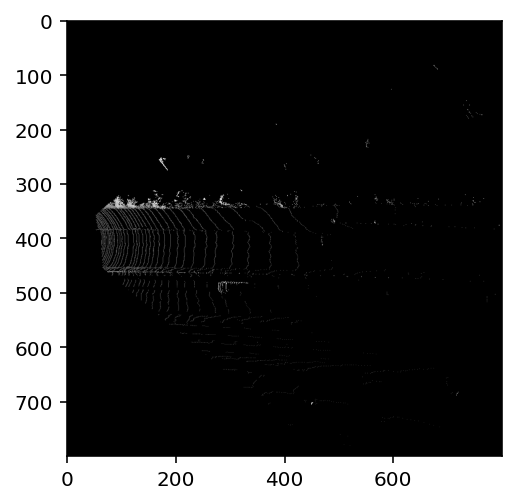

In [27]:
plt.imshow(bev_map)


In [28]:
example

{'points': array([[ 7.6693e+01,  4.6000e-02,  2.8020e+00,  0.0000e+00],
        [ 4.5127e+01,  3.0389e+01,  2.0490e+00,  0.0000e+00],
        [ 4.5031e+01,  3.0427e+01,  2.0470e+00,  0.0000e+00],
        ...,
        [ 6.4260e+00, -4.2000e-02, -1.6800e+00,  1.1000e-01],
        [ 6.4420e+00, -2.2000e-02, -1.6840e+00,  1.7000e-01],
        [ 6.4340e+00, -2.0000e-03, -1.6820e+00,  2.2000e-01]],
       dtype=float32),
 'voxels': tensor([[[ 17.3240, -14.8490,   0.9810,   0.1600],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000]],
 
         [[ 17.3250, -14.8030,   0.9800,   0.1300],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000]],
 
         [[ 17.2980, -14.5930,   0.9740,   0.

In [29]:
example = example_convert_to_torch(example, device=torch.device("cuda"))


voxels = example["voxels"]
num_points = example["num_points"]
coors = example["coordinates"]
batch_anchors = example["anchors"]
feature = example["feature"]
batch_size_dev = batch_anchors.shape[0]
# vfeatures = net.voxel_feature_extractor(voxels, num_points, coors)
# preds_dict = net.network_forward(voxels, num_points, coors, batch_size_dev)
spatial_features = net.feature_extractor(feature)

/home/gx/GitHub/depconv/second/pytorch/train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v, dtype=torch.float32, device=device).to(dtype)
/home/gx/GitHub/depconv/second/pytorch/train.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v, dtype=torch.int32, device=device)
/home/gx/GitHub/depconv/second/pytorch/train.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  example_torch[k] = torch.tensor(v)
/home/gx/GitHub/depconv/second/pytorch/train.py:52: UserWarning: To copy construct from a tensor, it is recommended to use source

D_min, D_max=  tensor(0, device='cuda:0') tensor(63, device='cuda:0')
shape BCDHW,  1 64 64 2 64


In [30]:
spatial_features.shape

torch.Size([1, 128, 64, 64])

/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


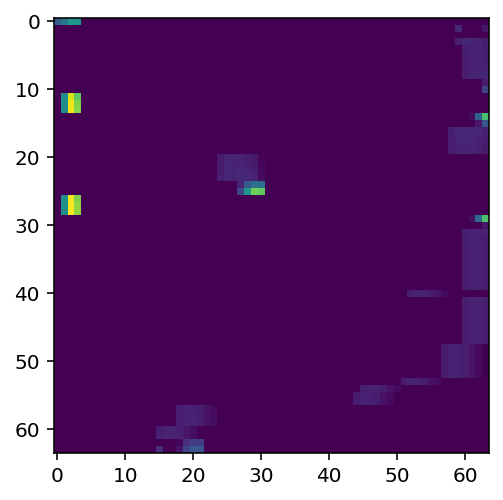

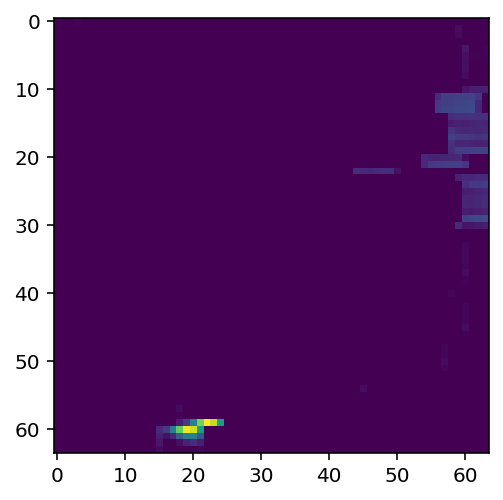

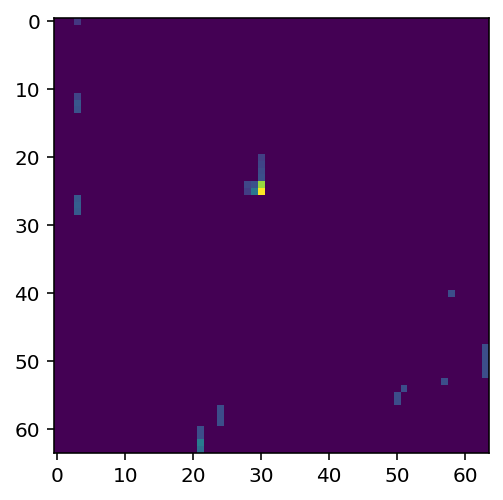

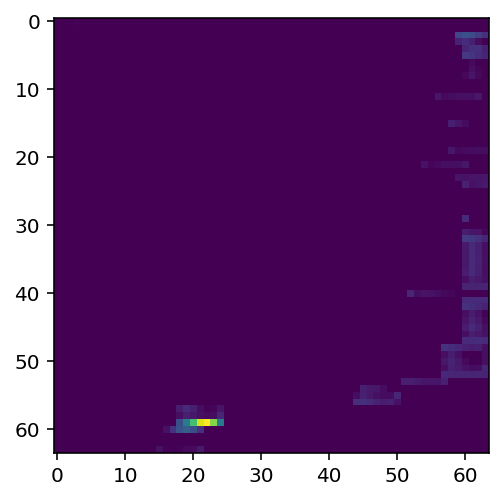

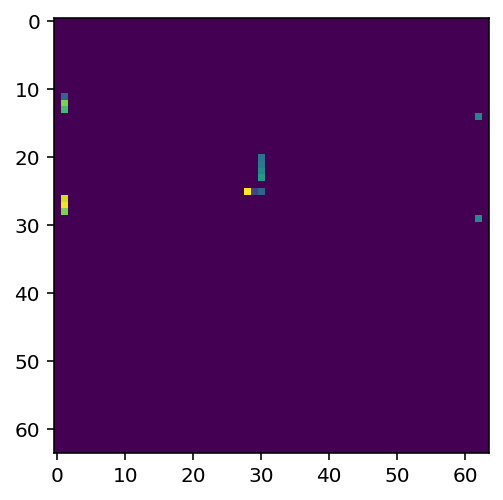

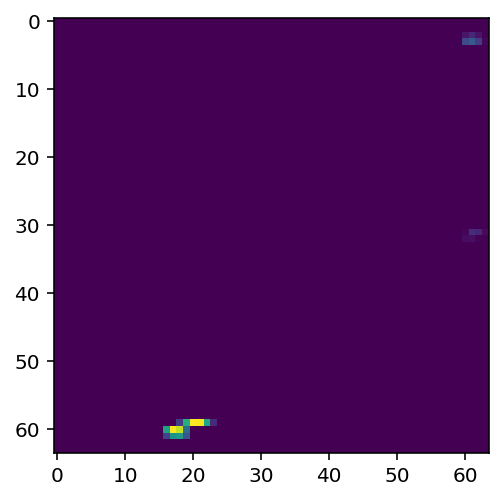

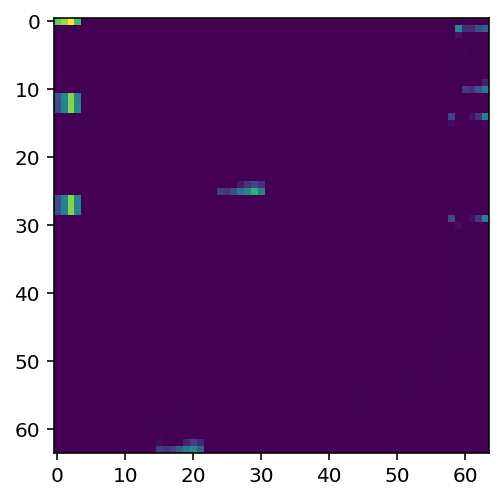

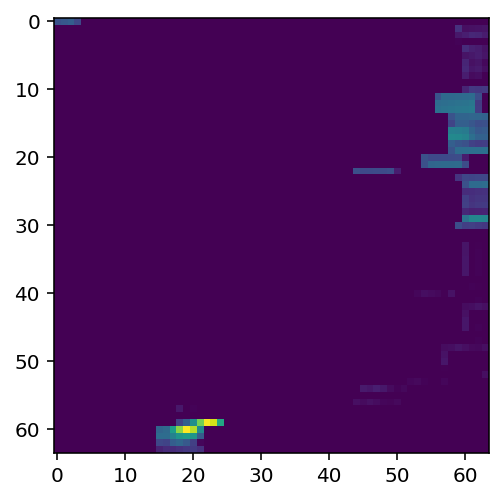

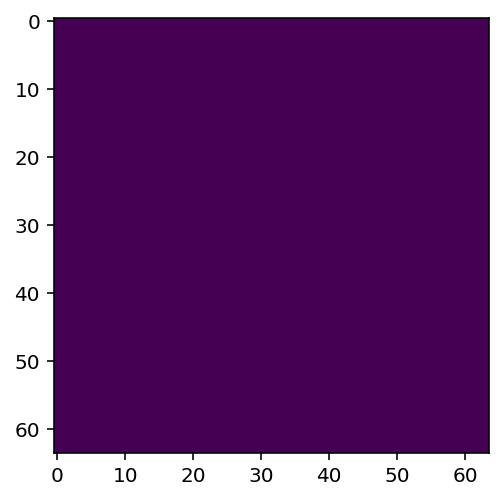

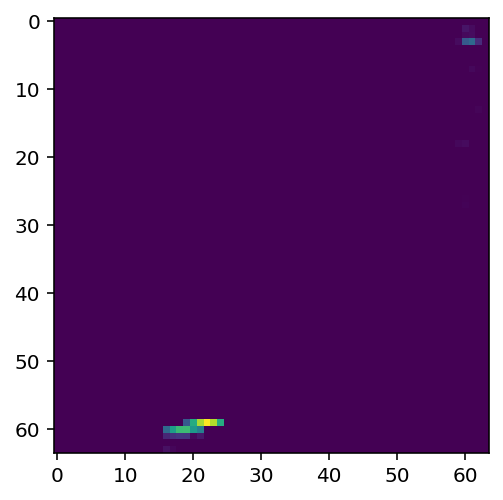

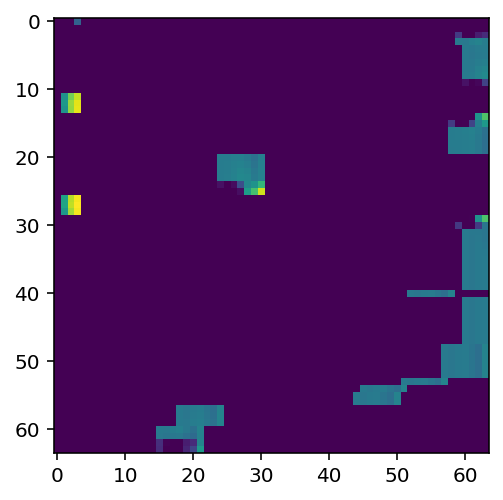

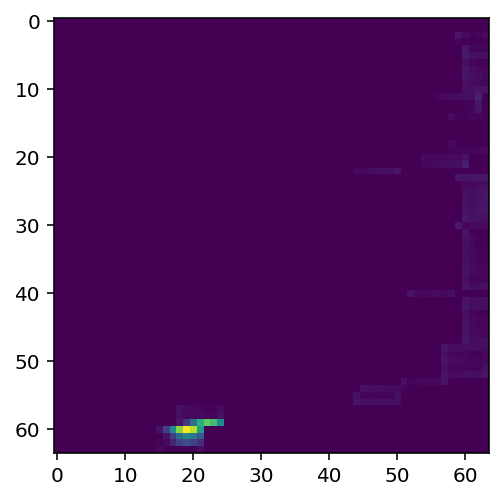

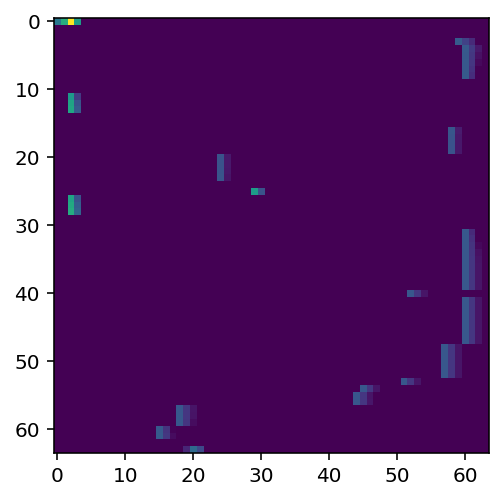

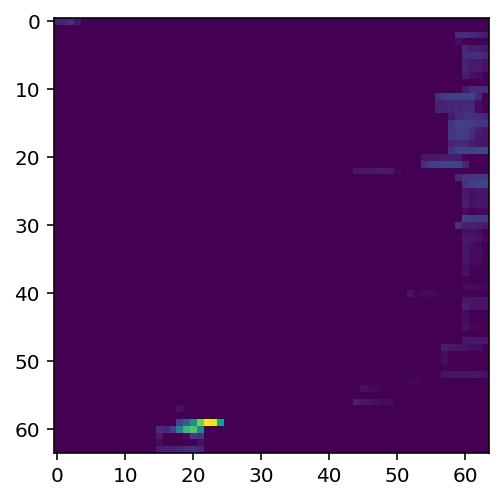

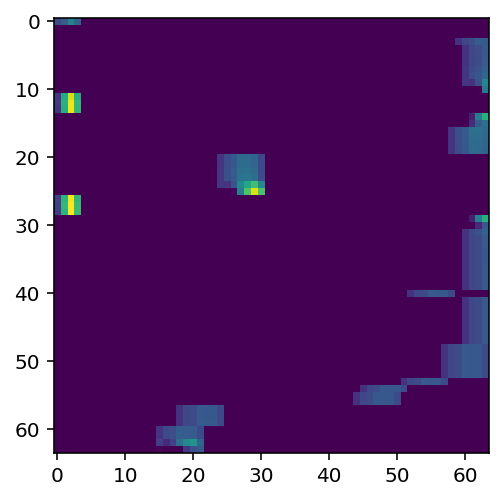

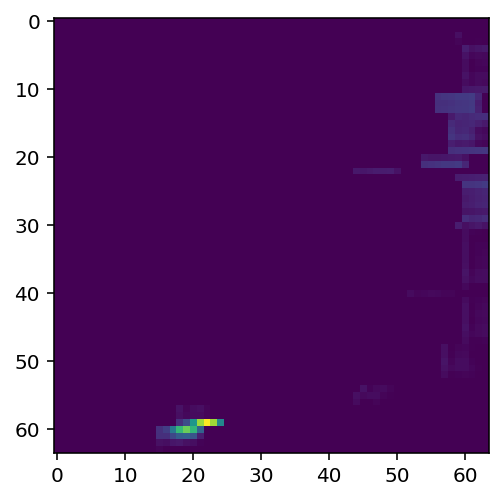

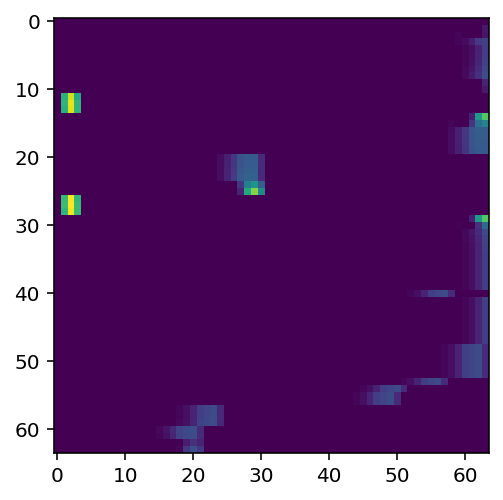

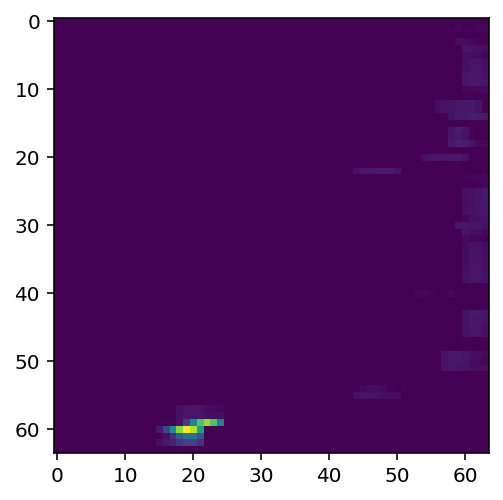

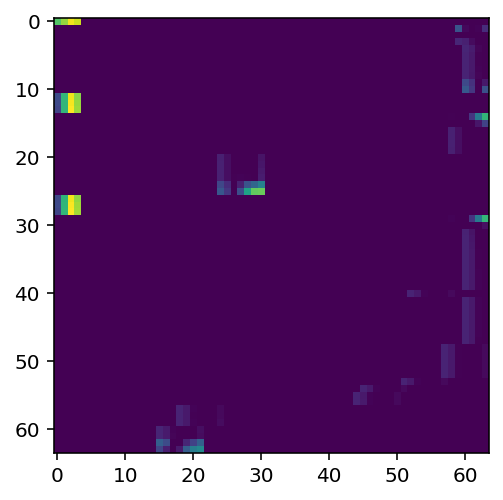

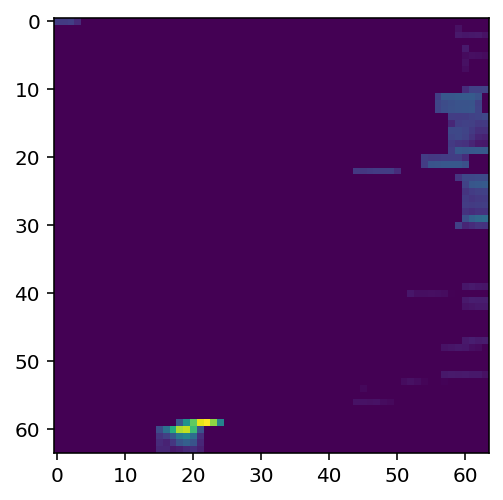

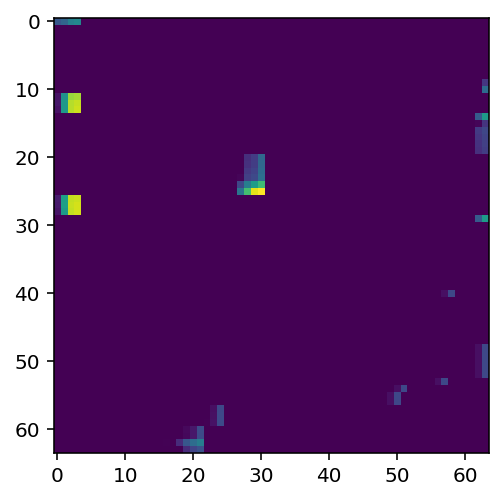

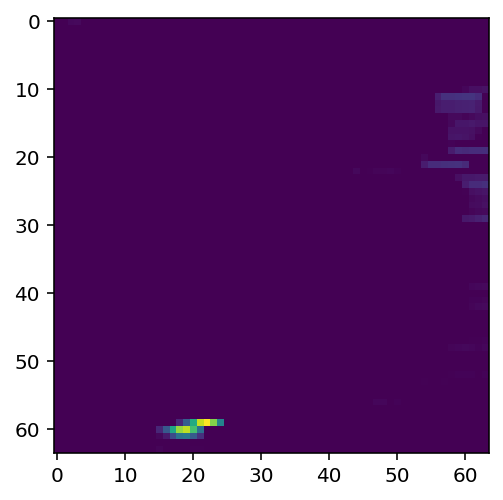

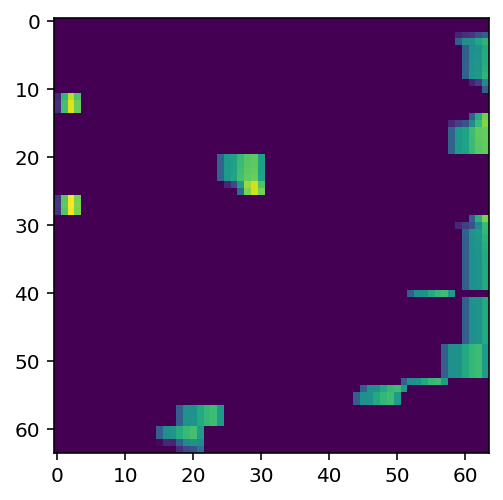

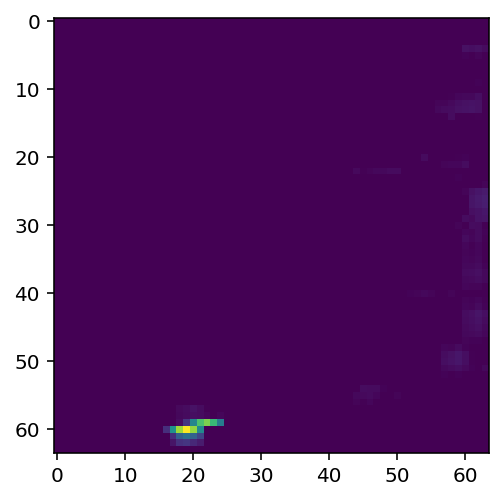

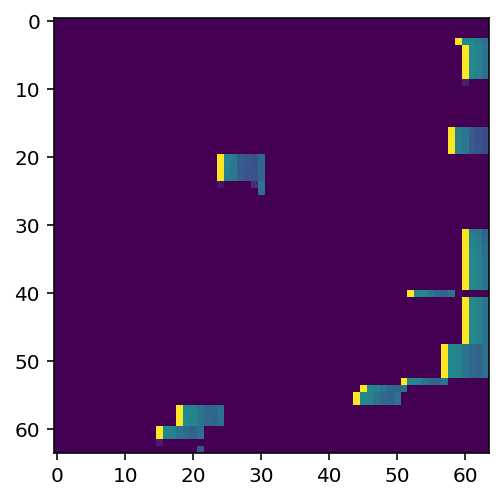

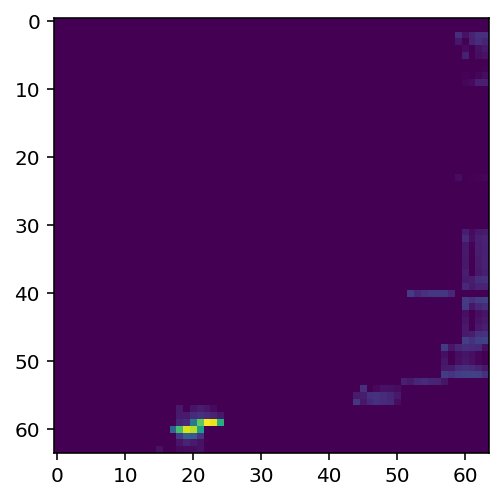

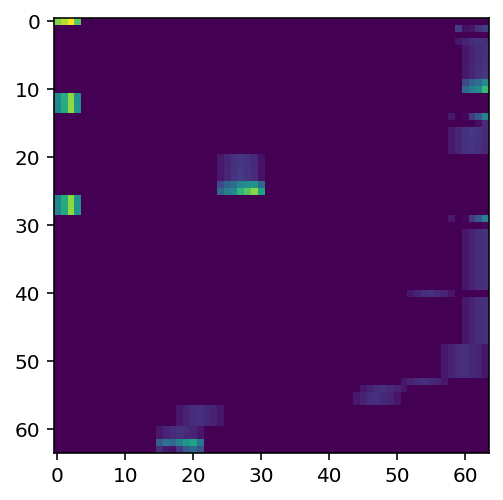

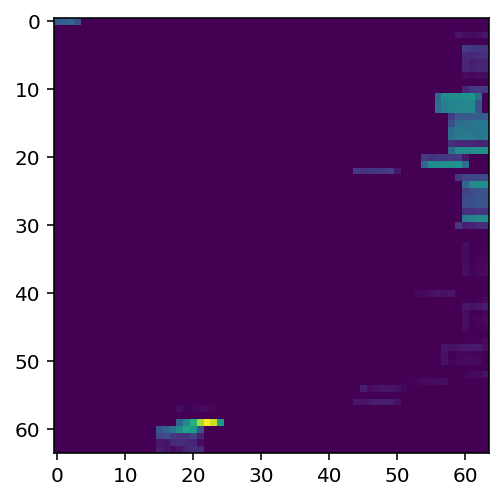

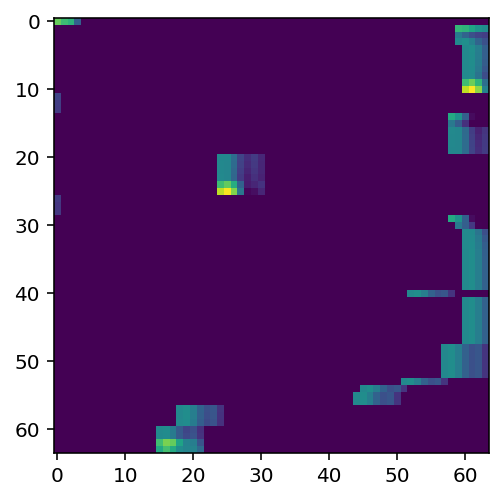

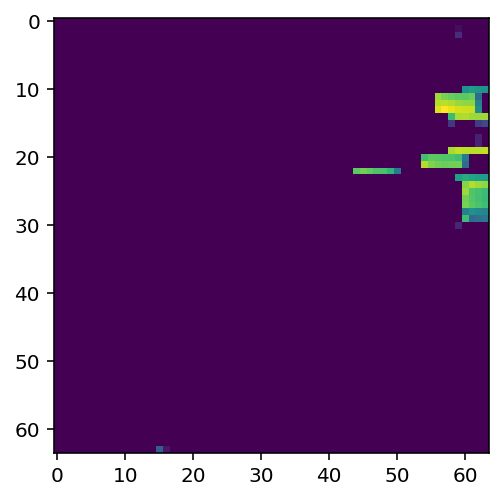

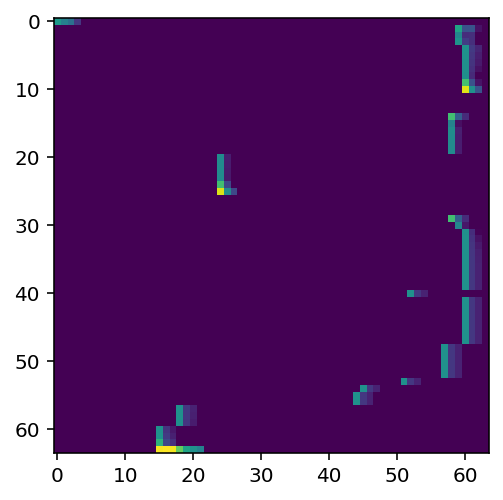

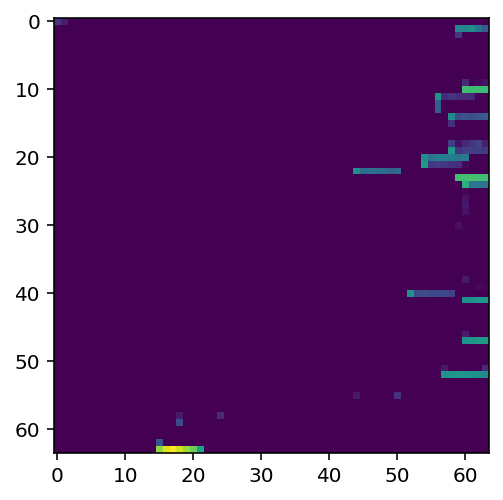

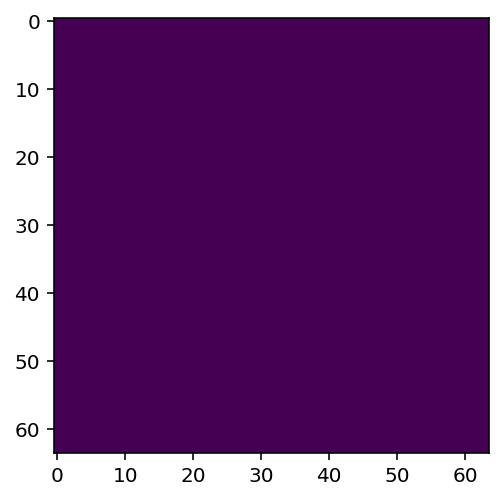

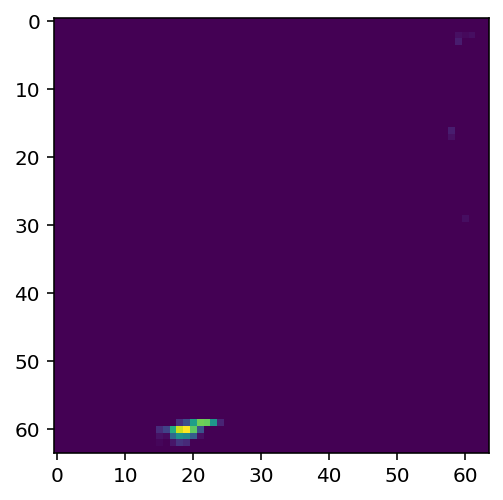

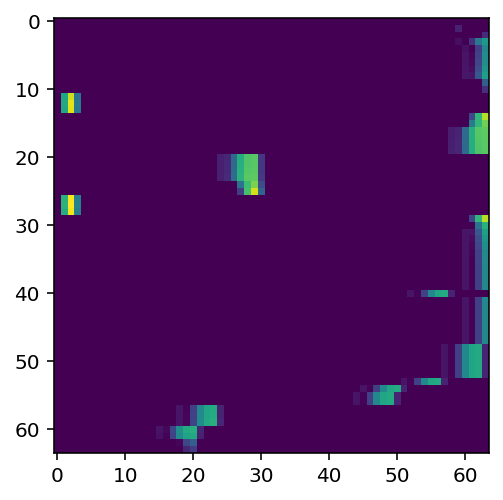

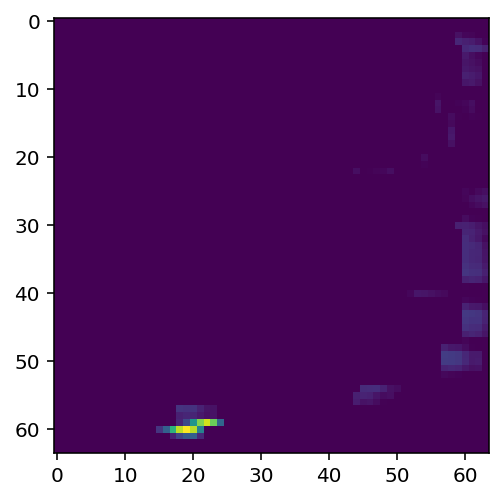

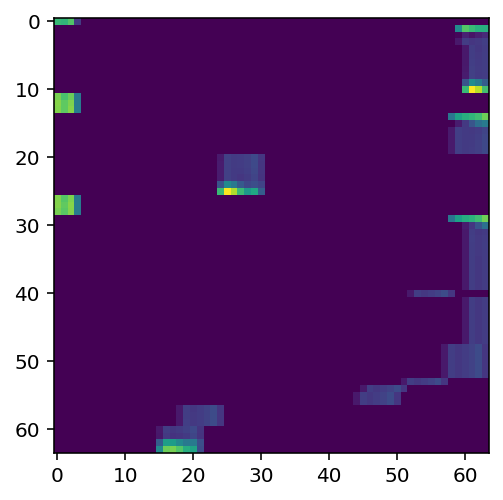

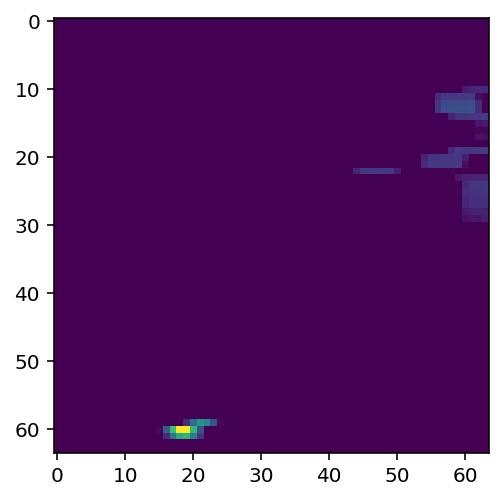

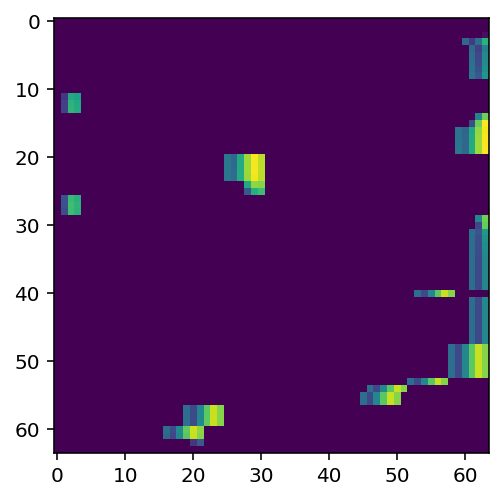

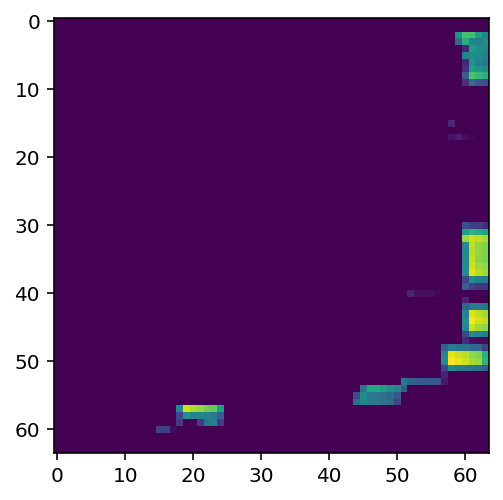

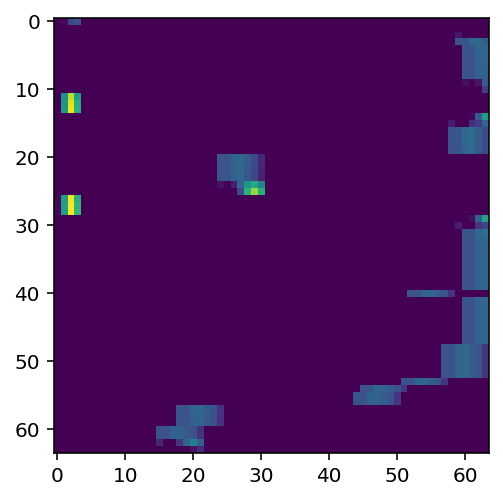

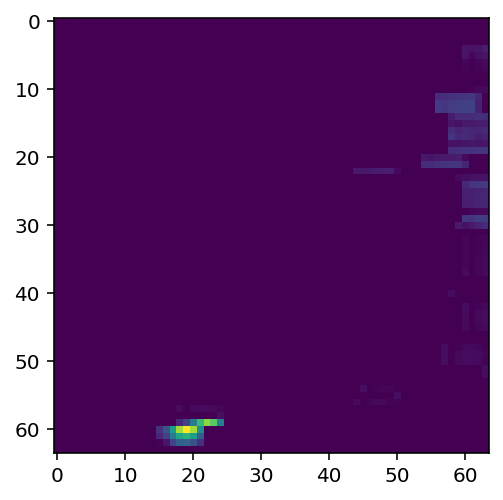

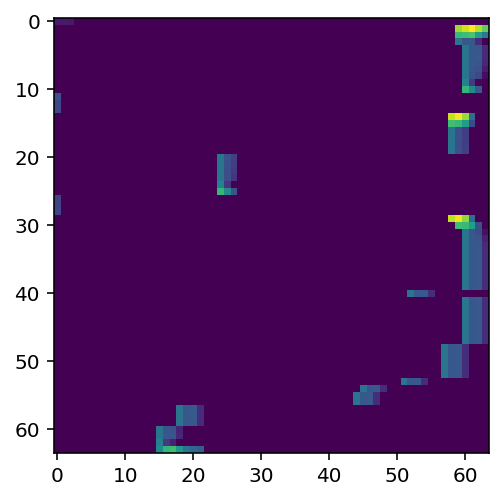

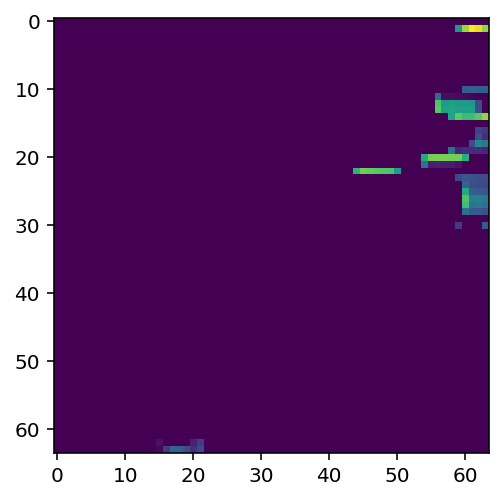

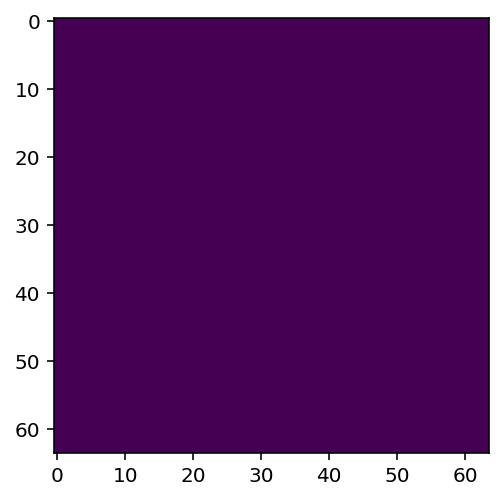

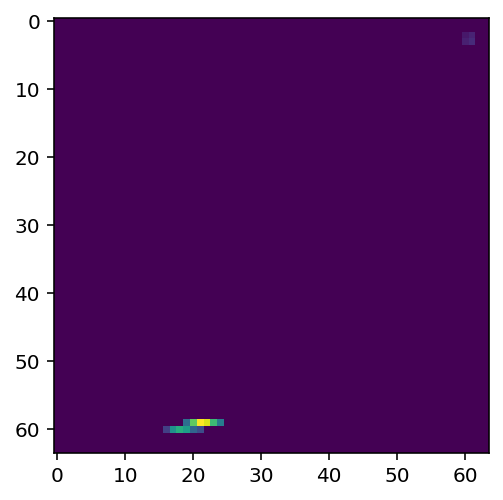

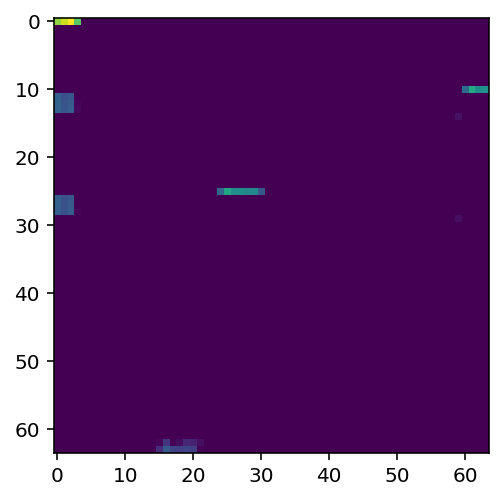

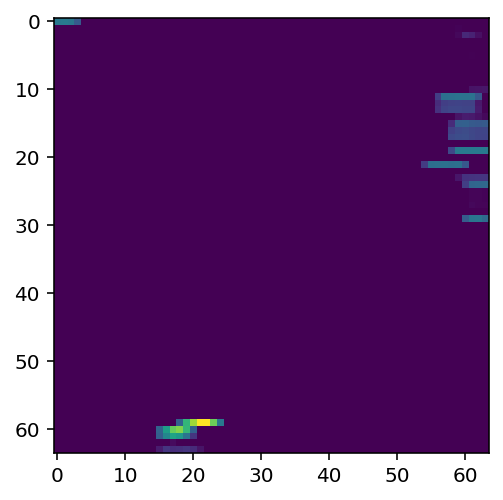

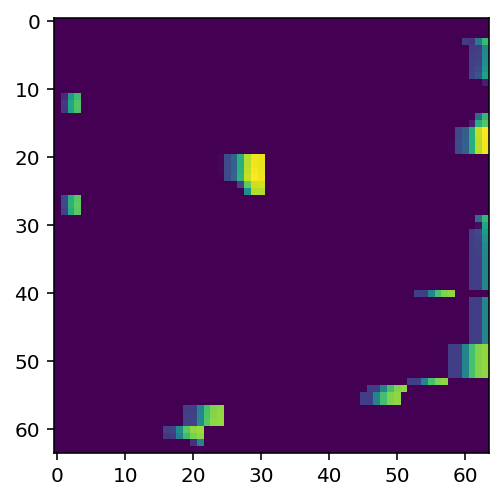

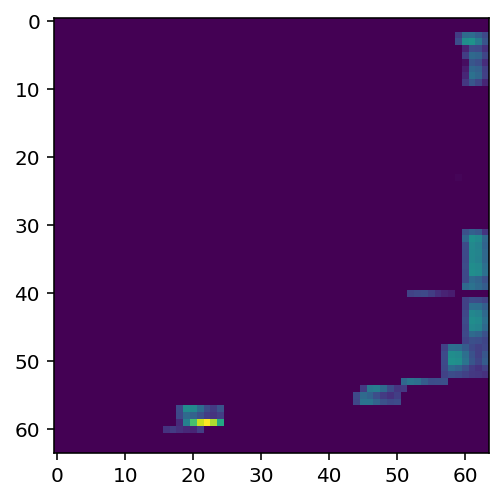

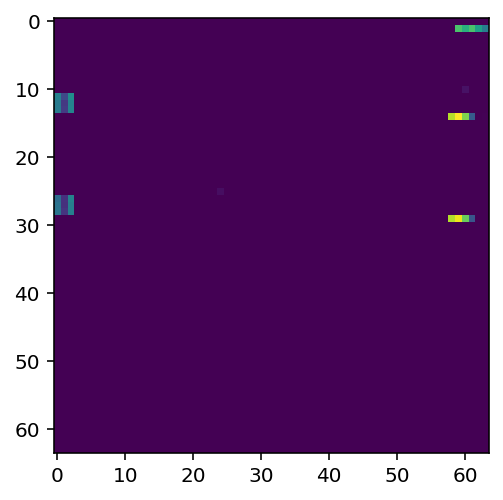

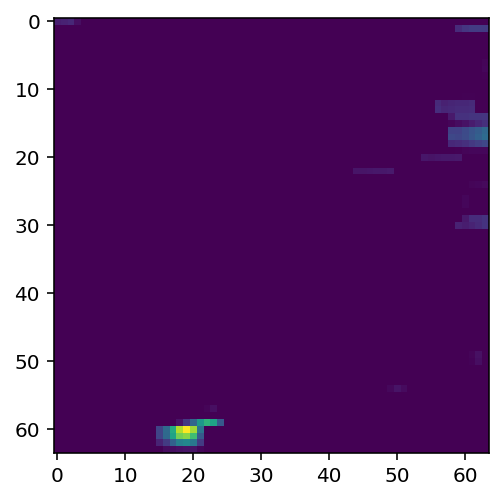

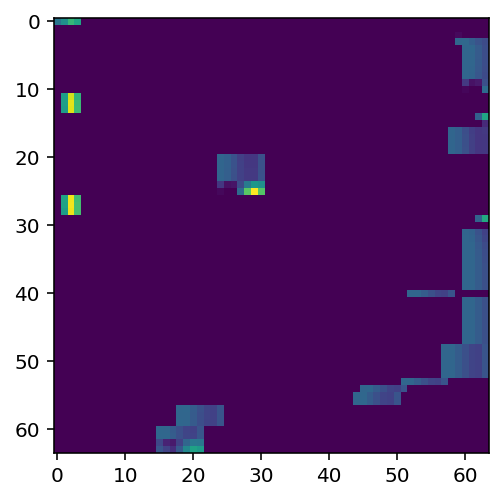

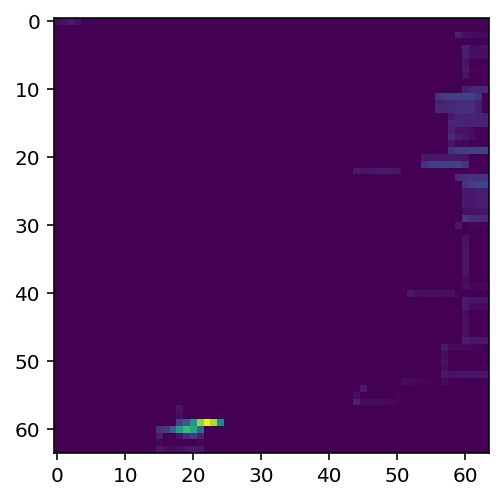

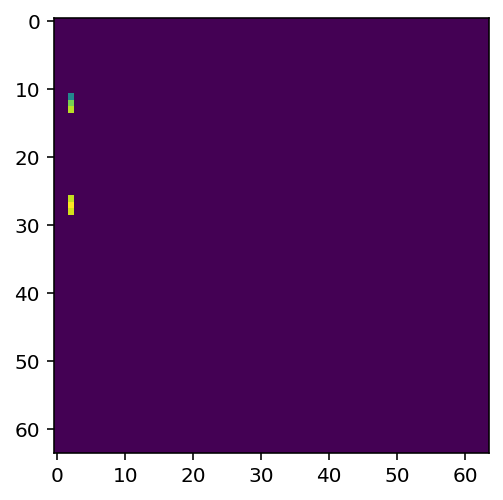

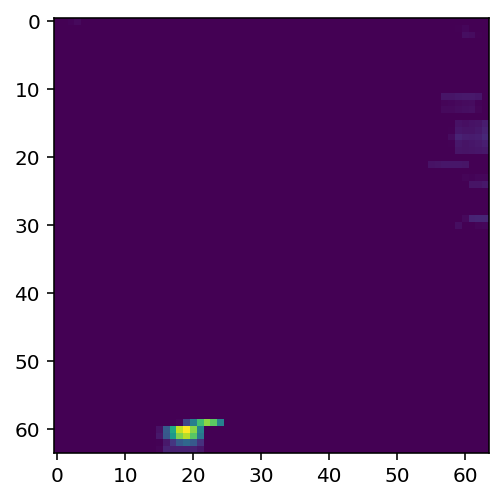

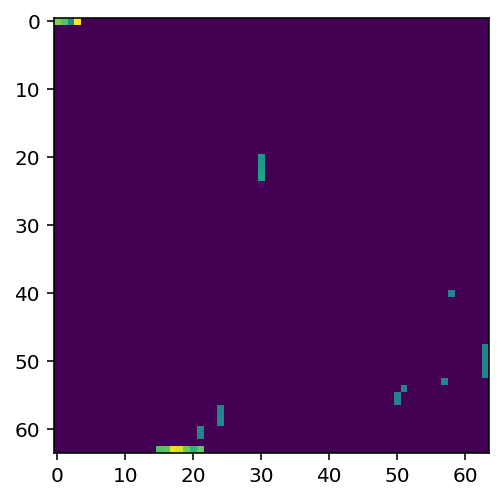

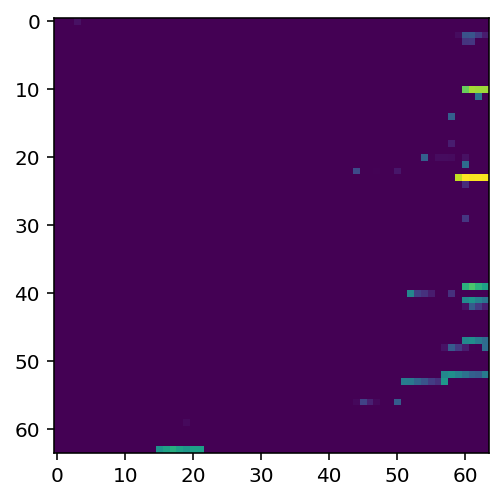

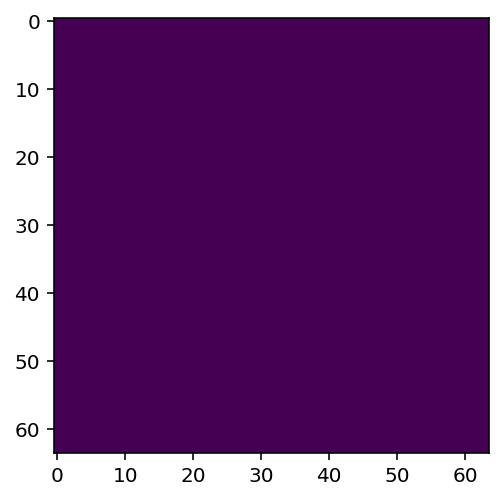

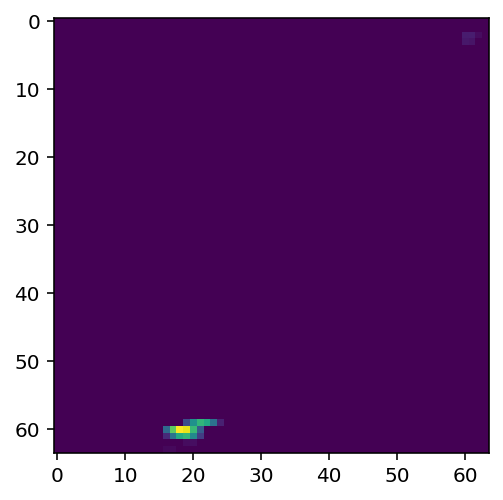

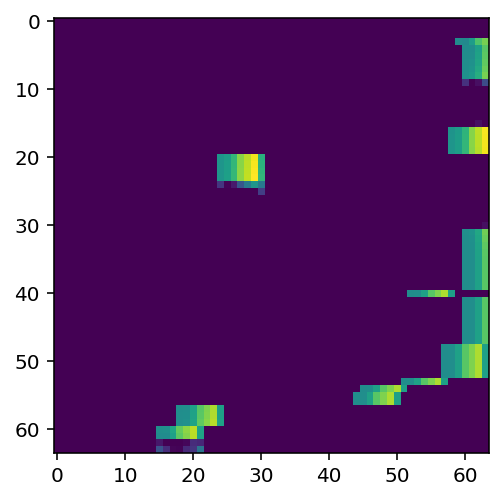

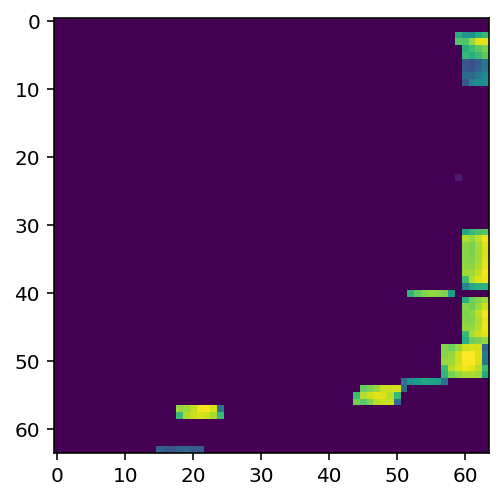

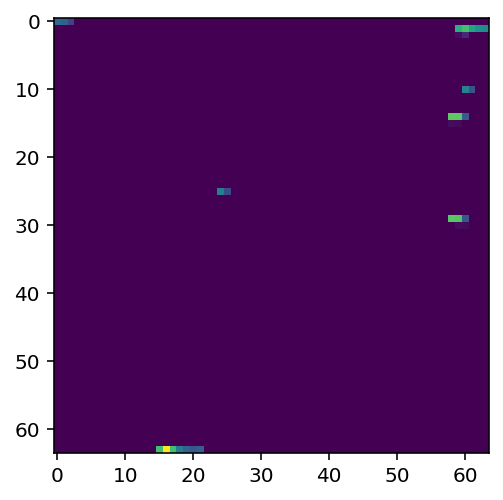

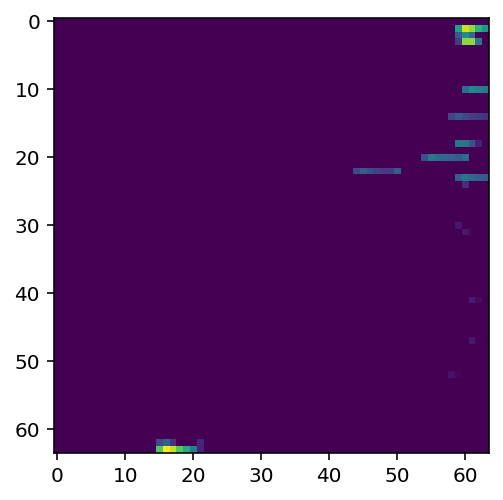

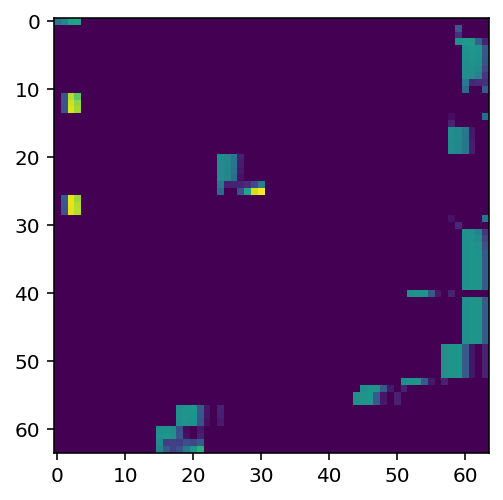

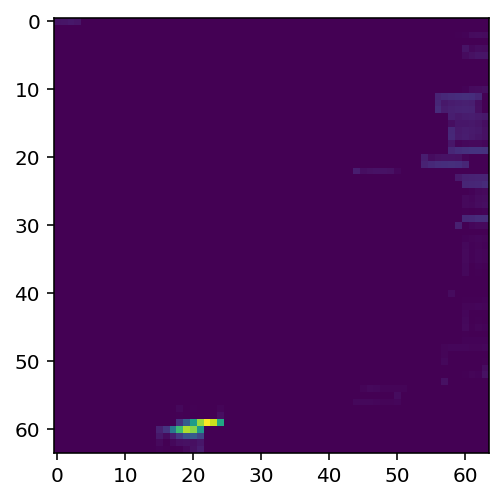

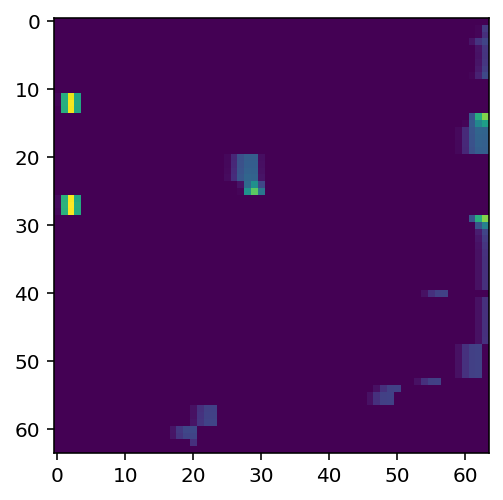

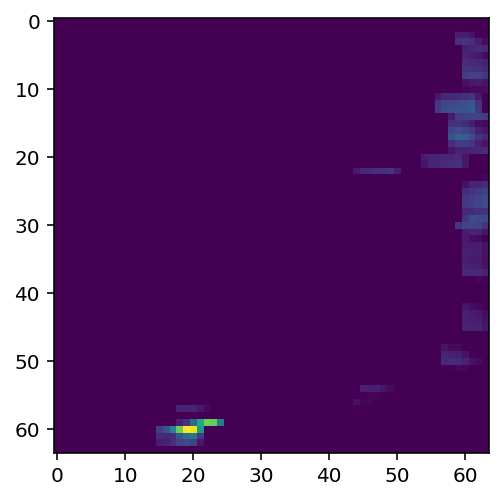

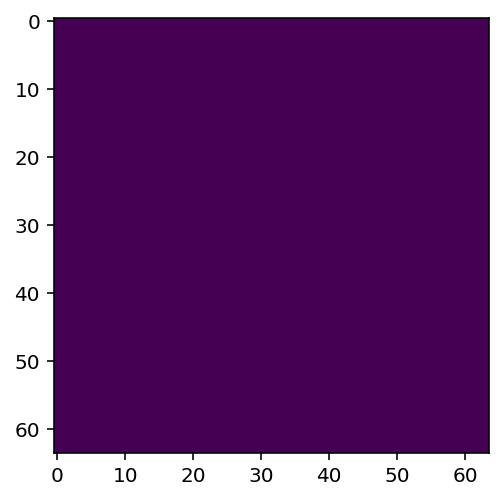

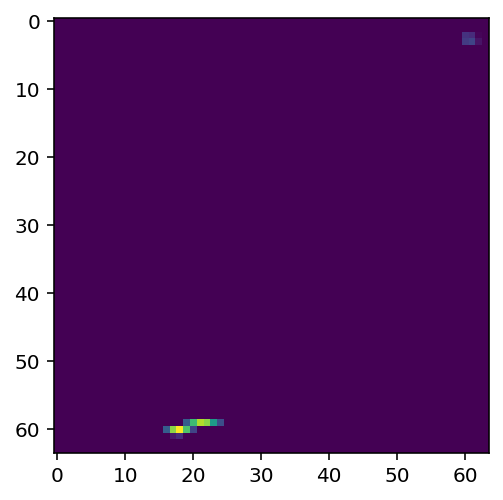

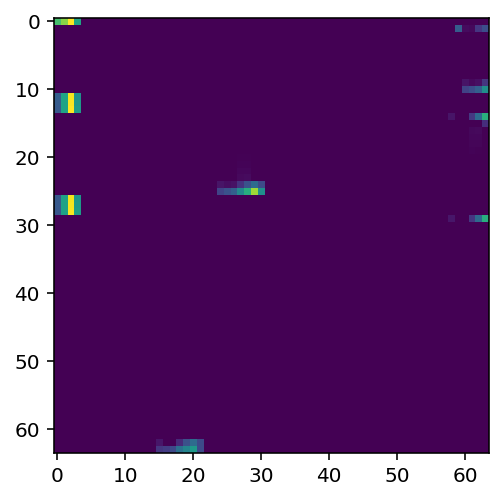

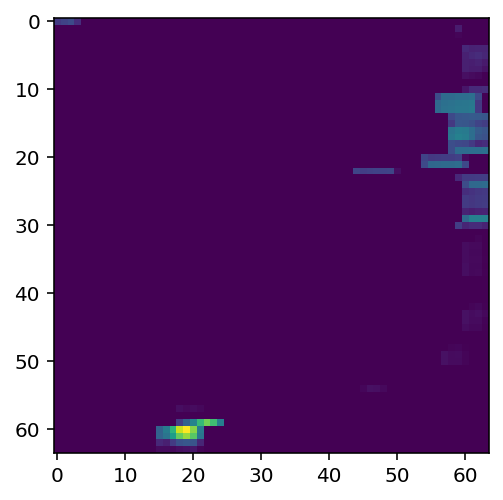

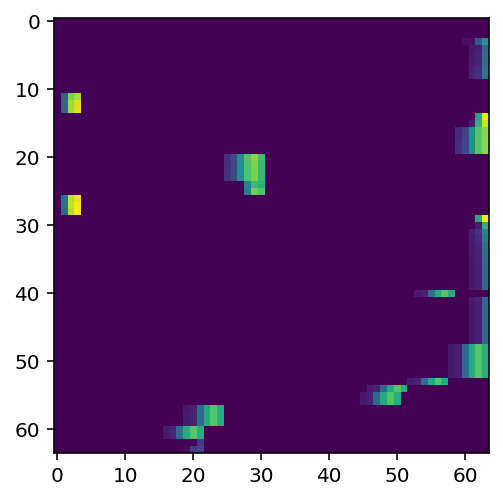

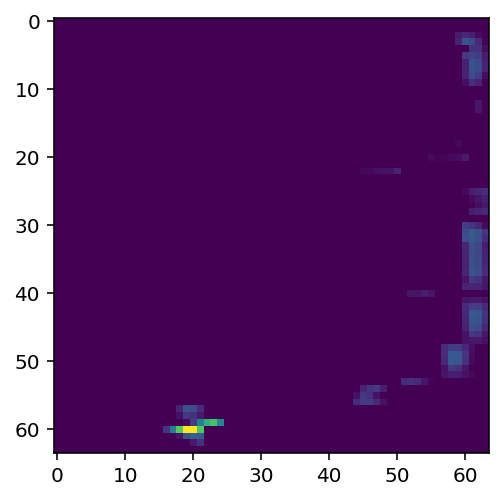

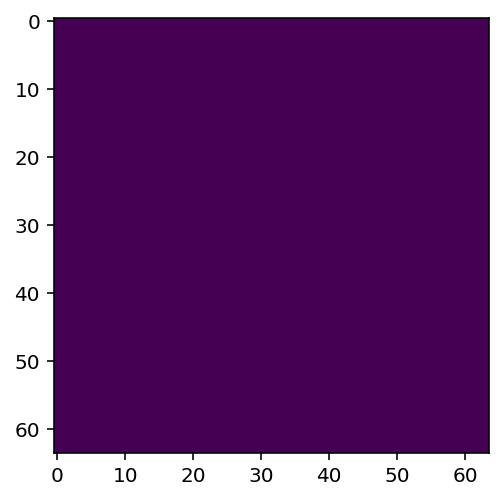

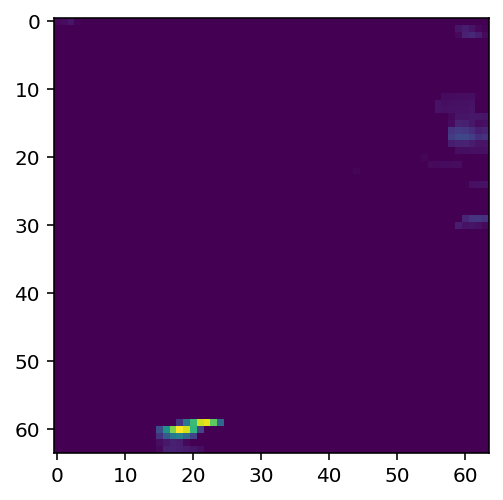

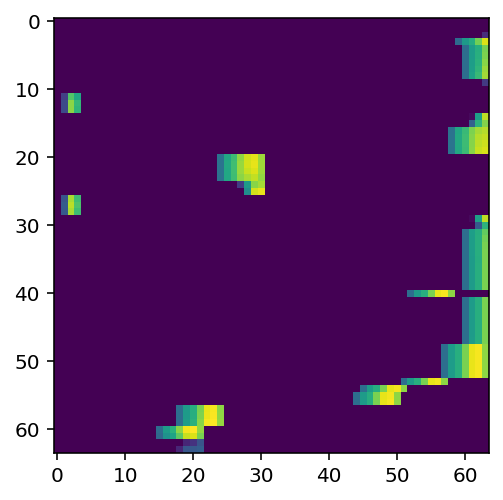

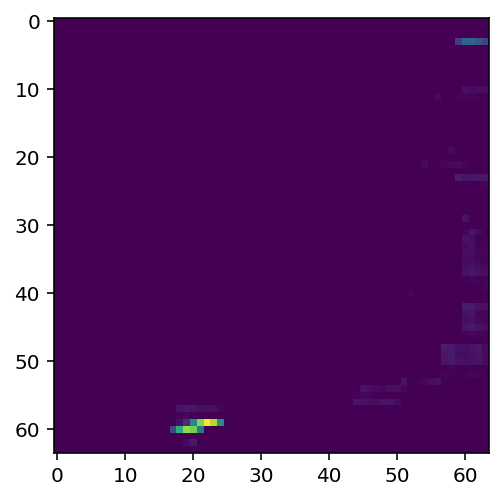

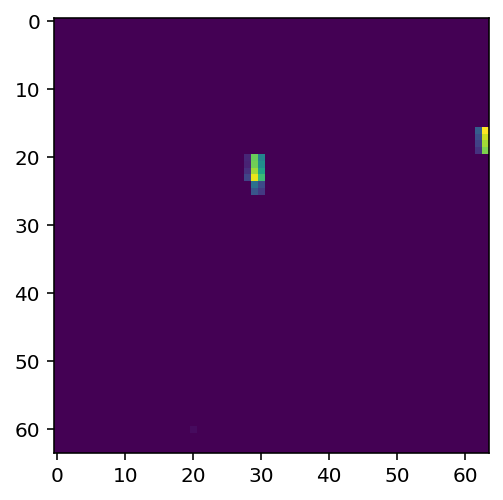

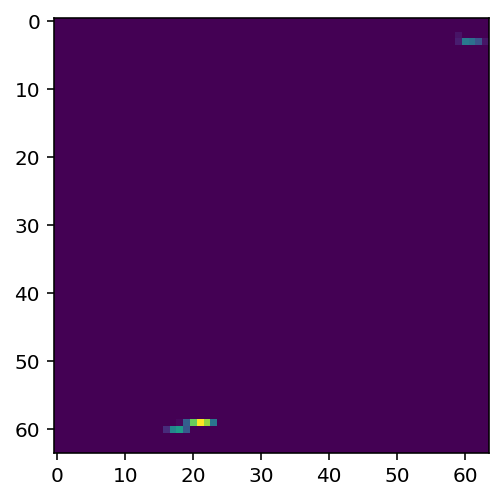

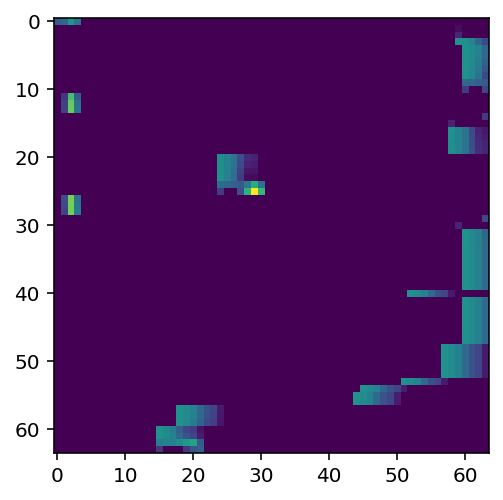

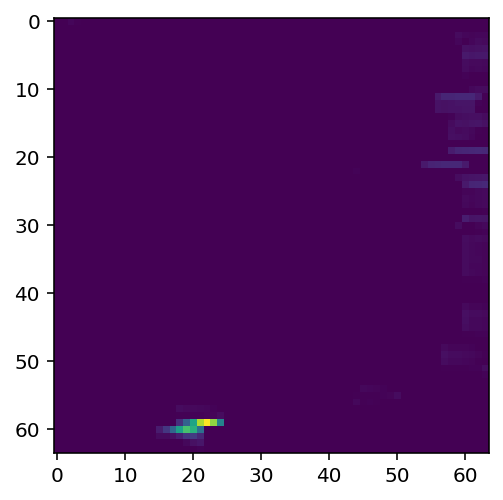

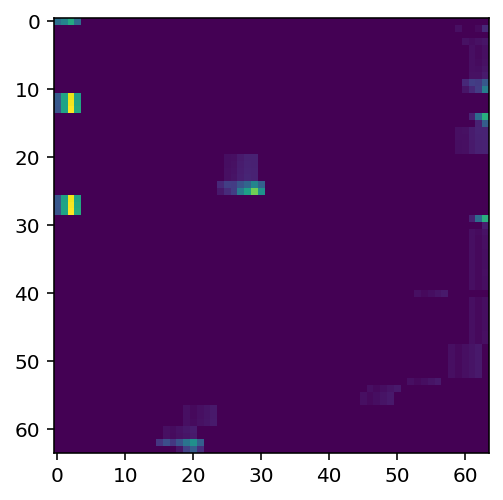

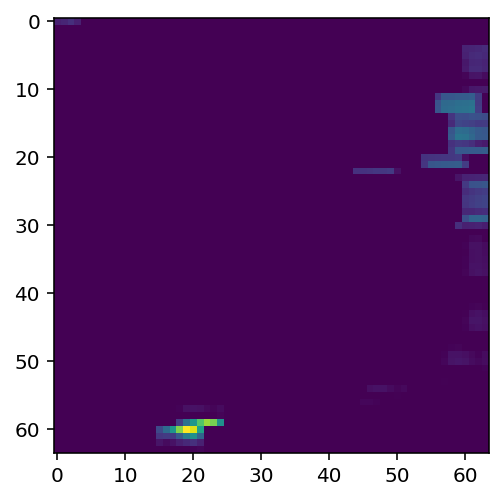

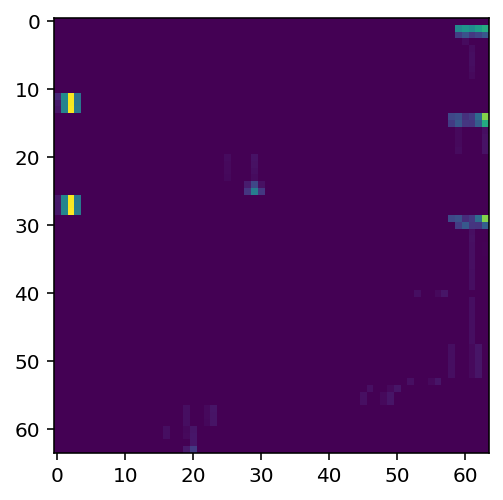

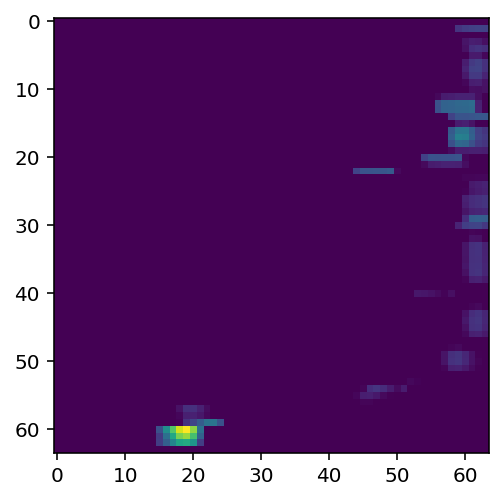

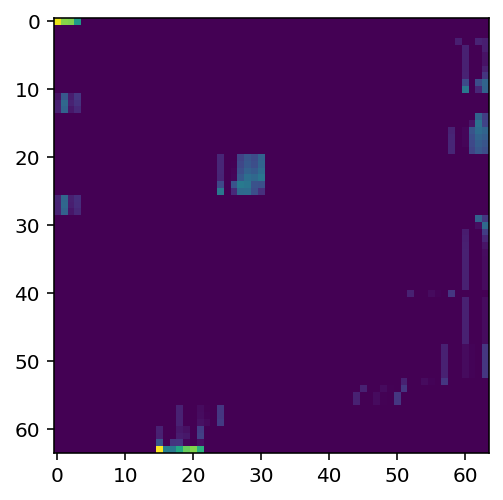

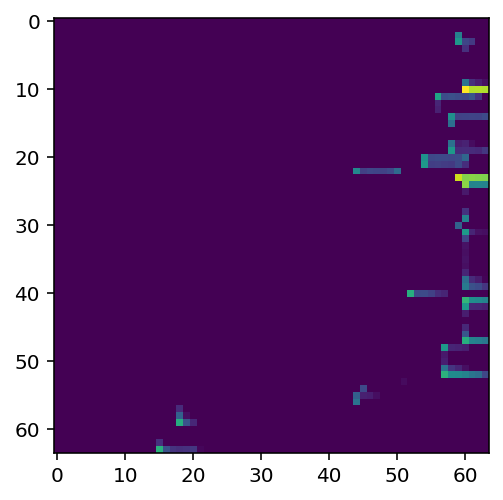

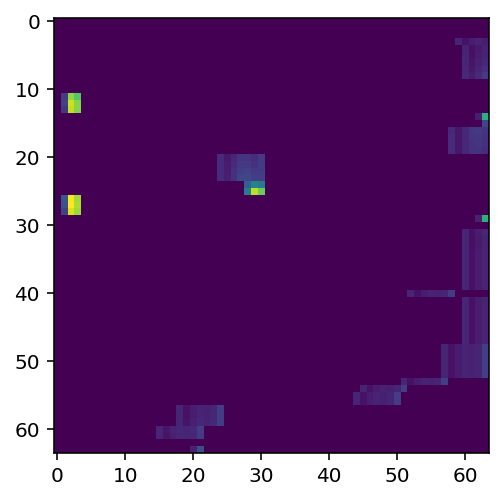

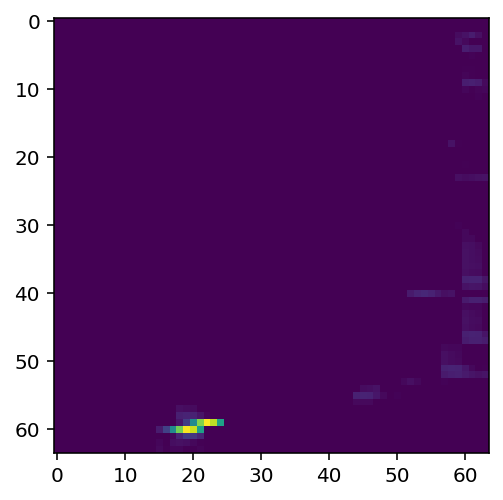

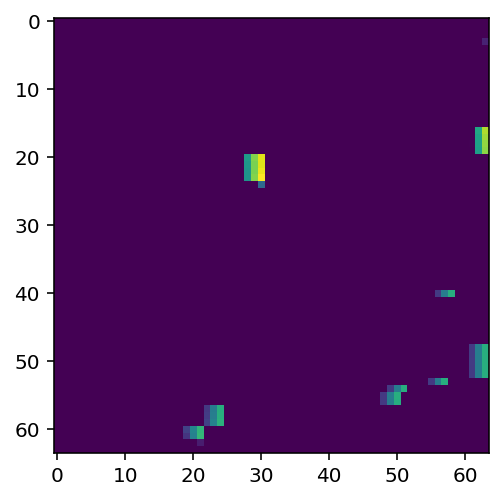

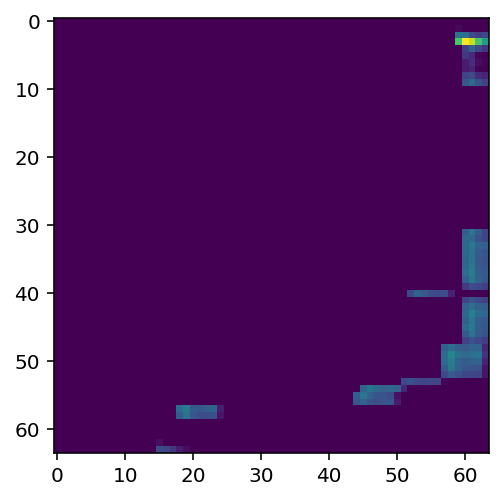

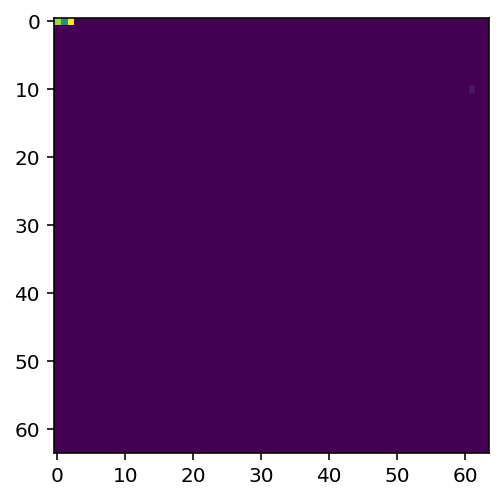

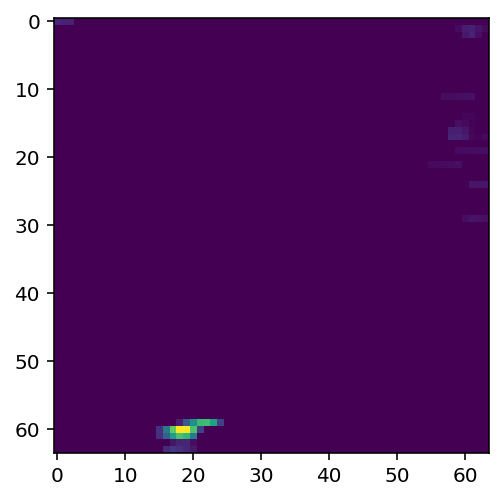

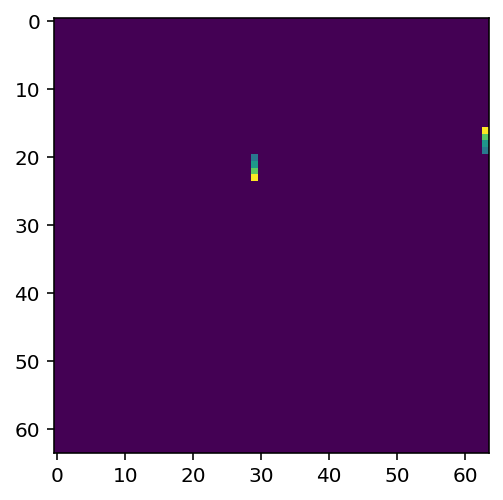

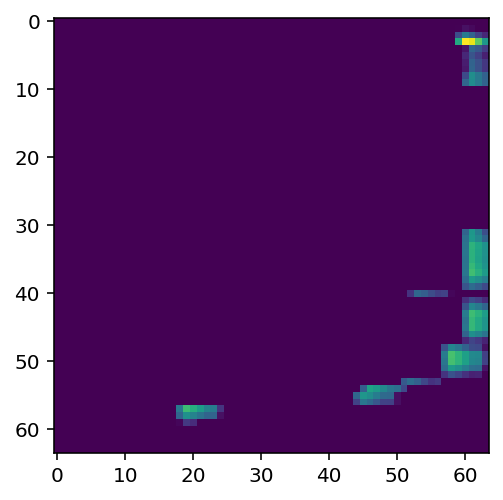

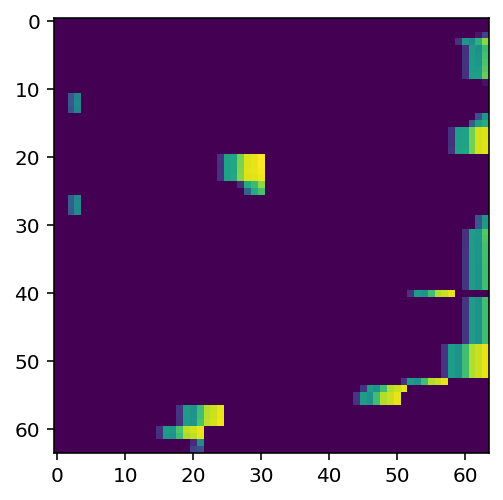

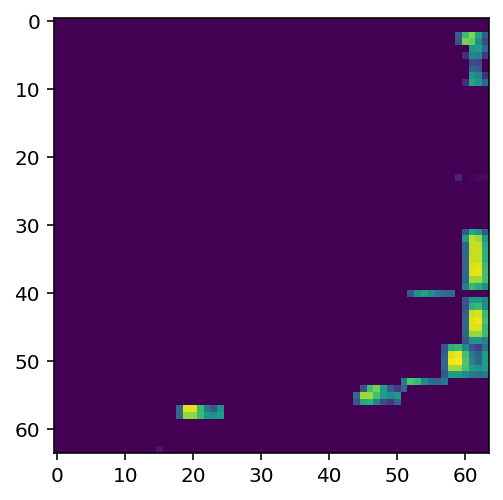

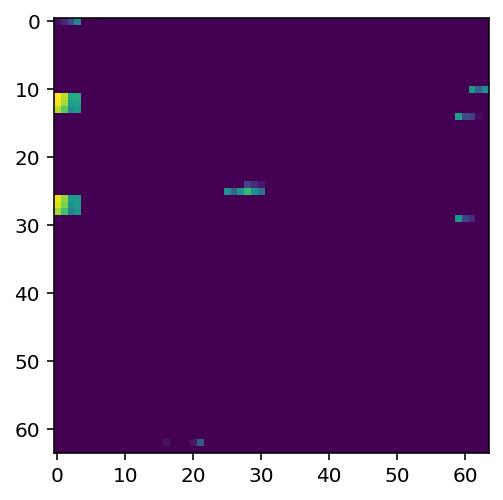

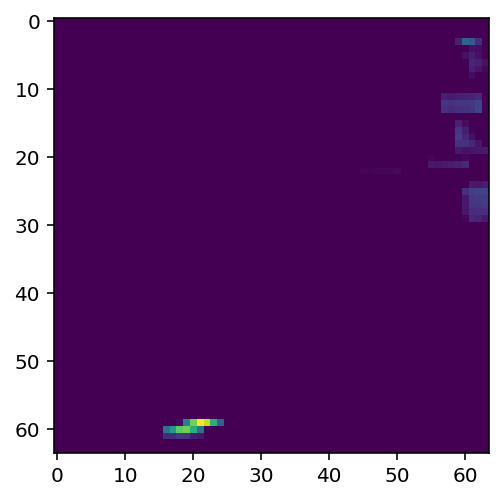

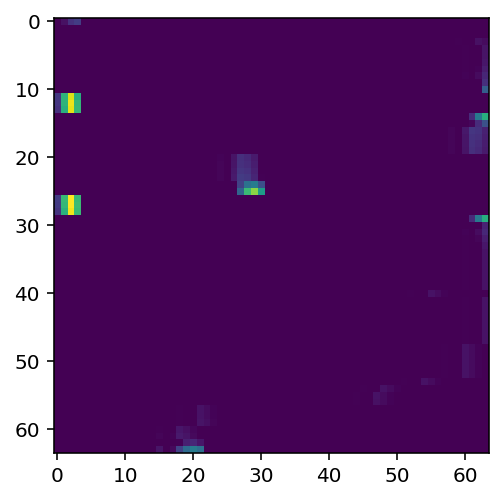

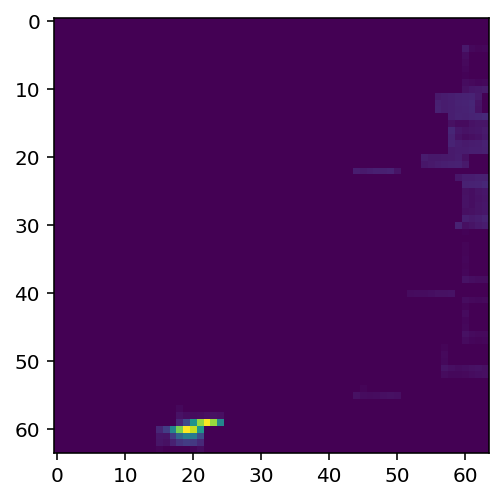

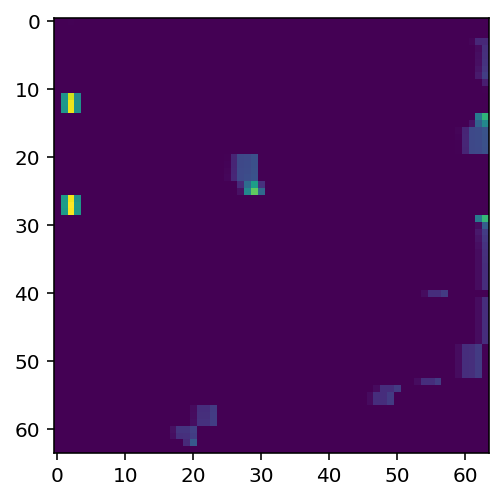

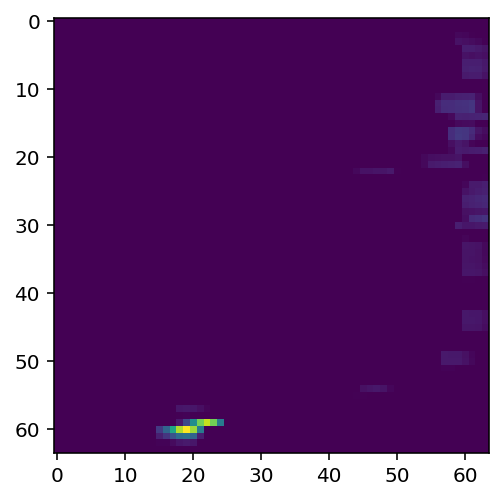

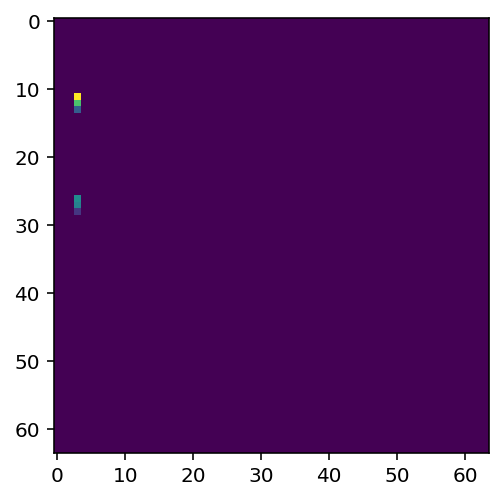

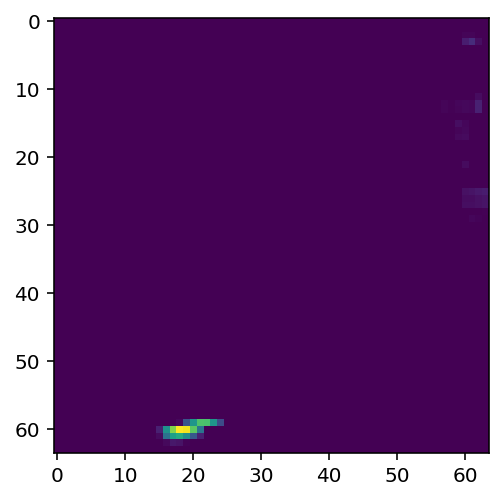

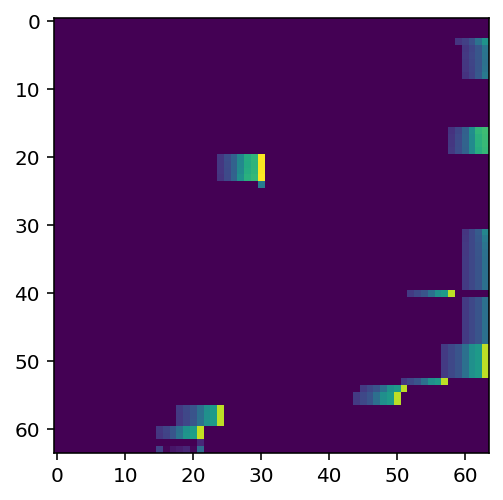

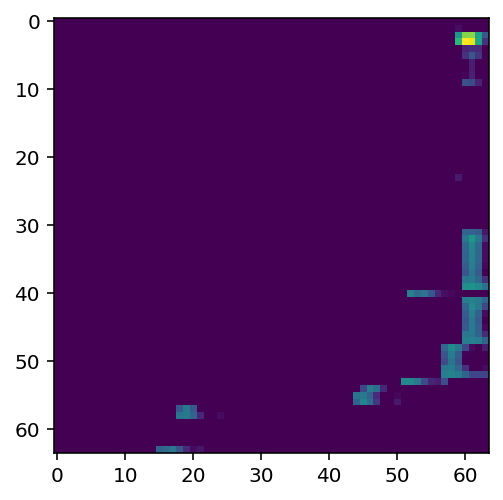

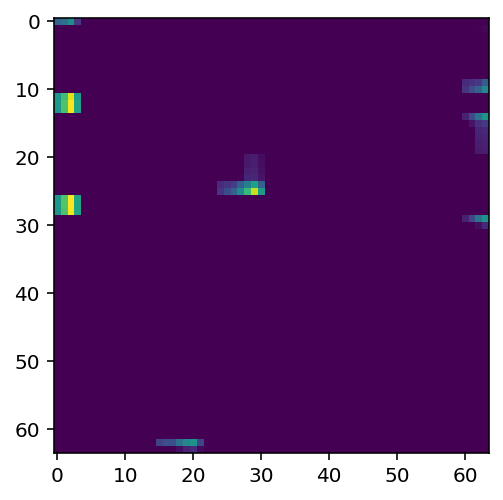

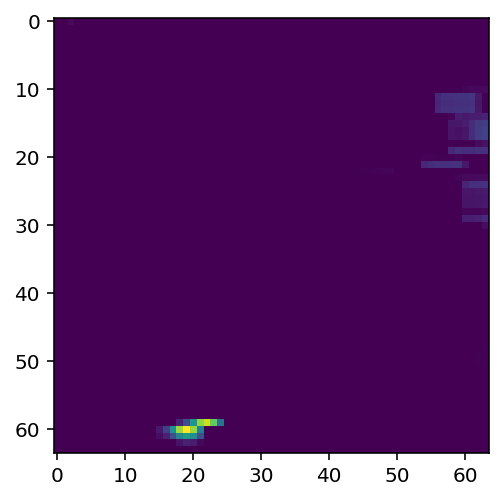

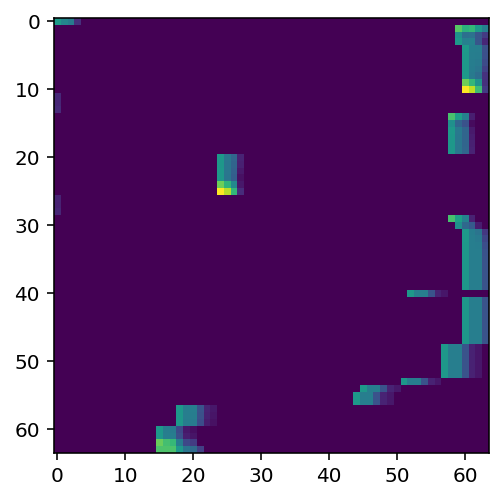

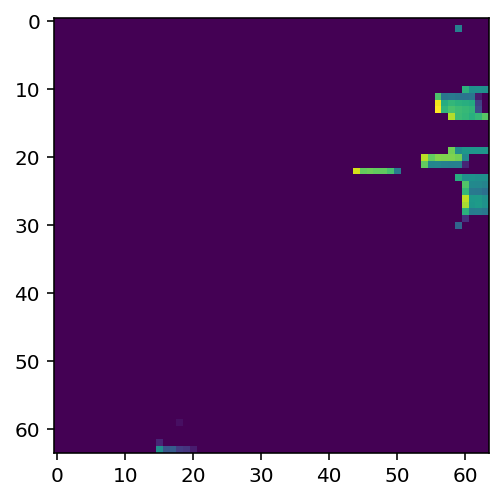

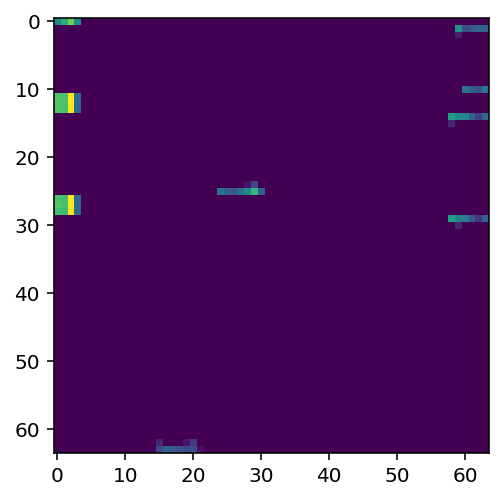

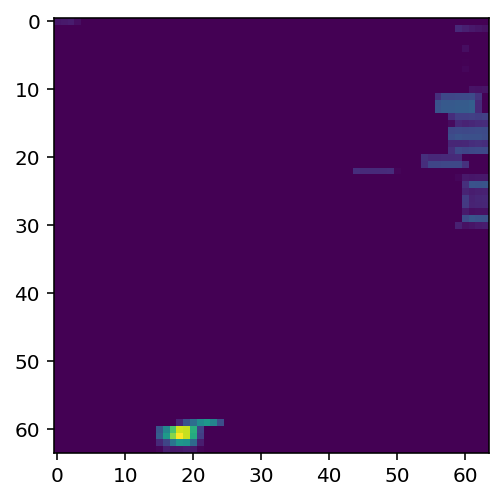

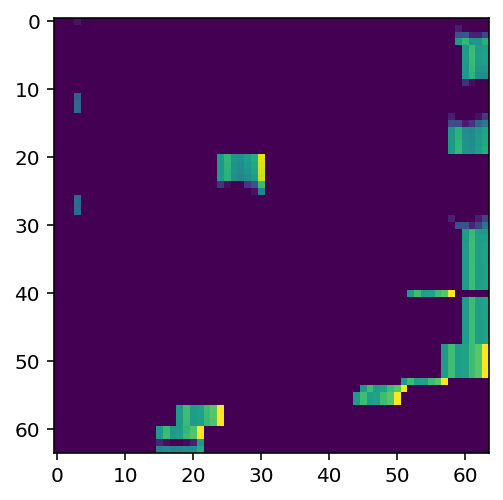

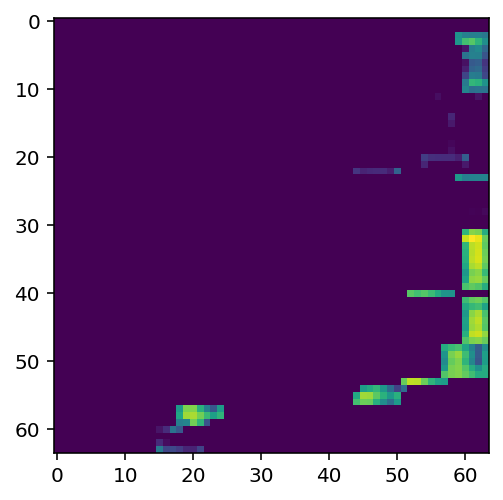

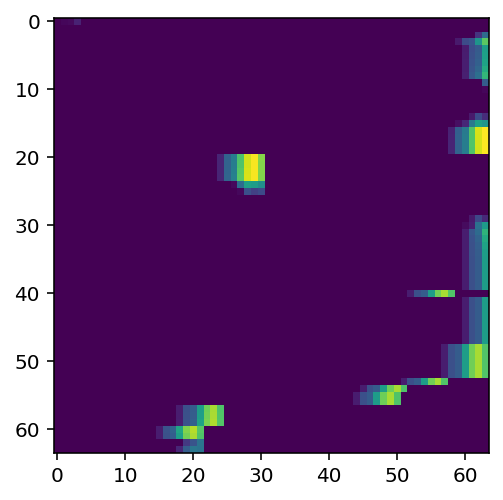

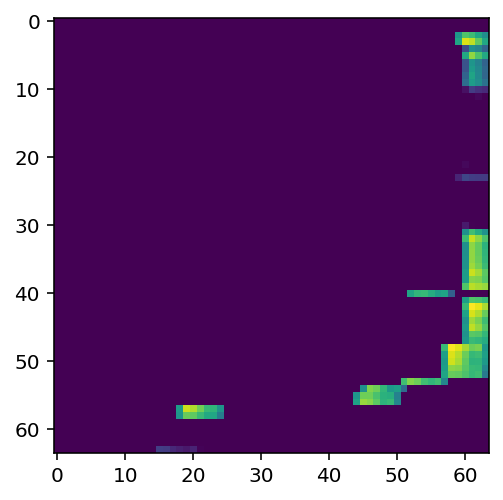

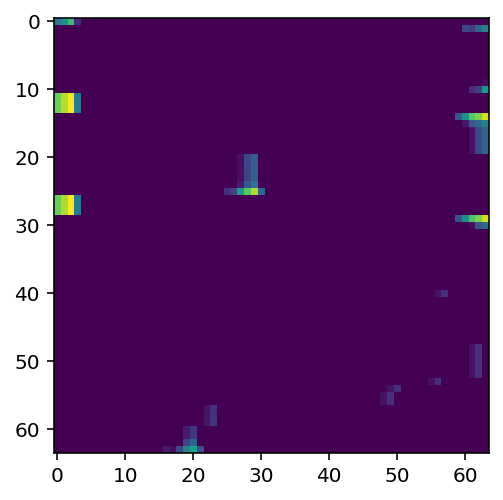

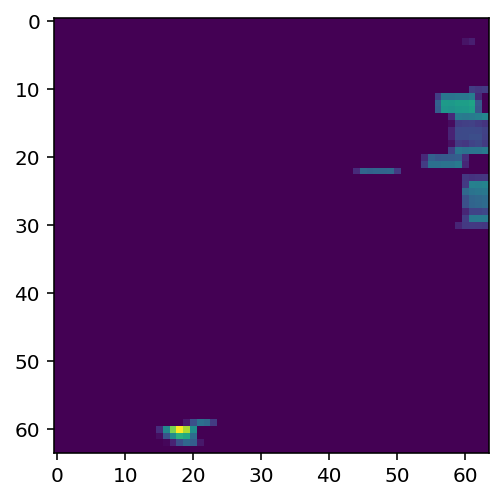

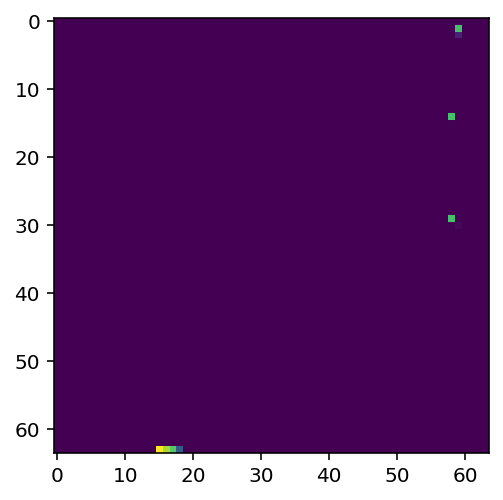

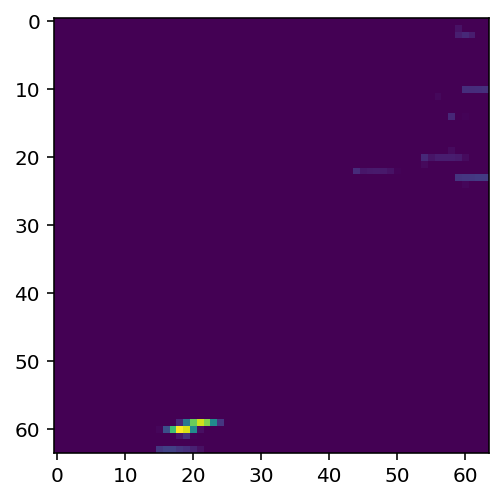

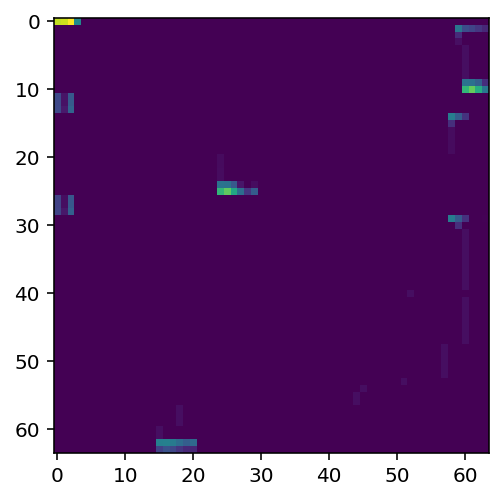

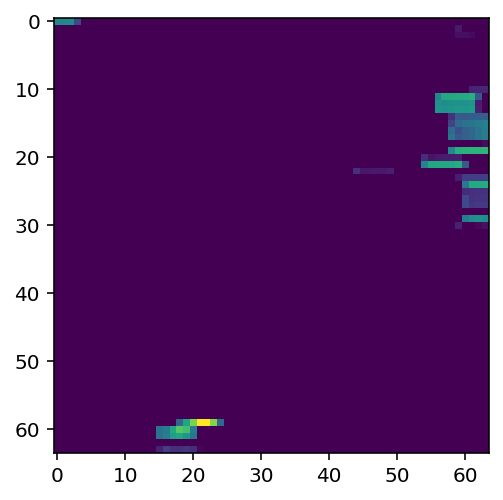

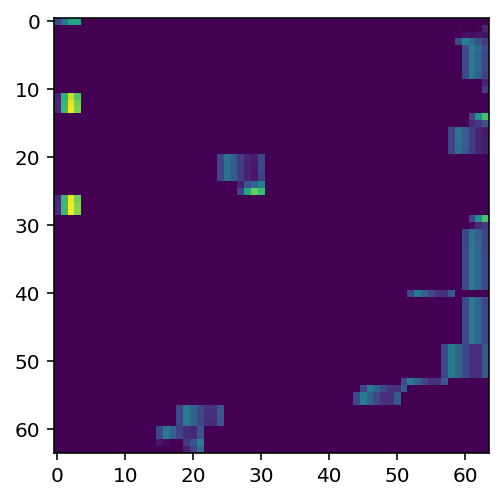

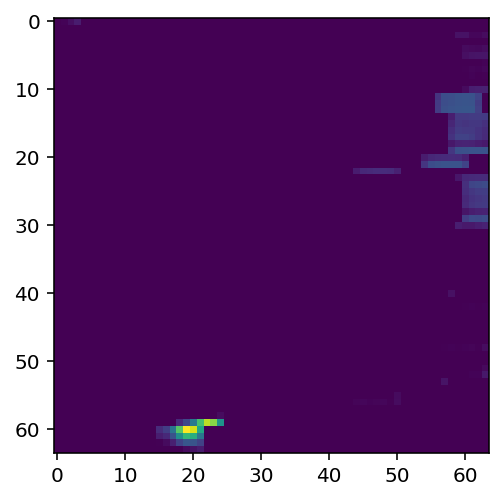

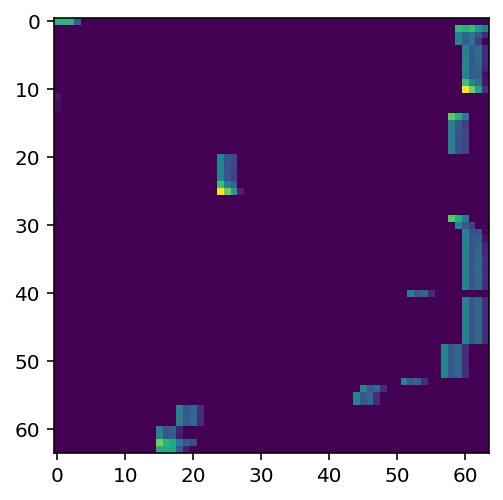

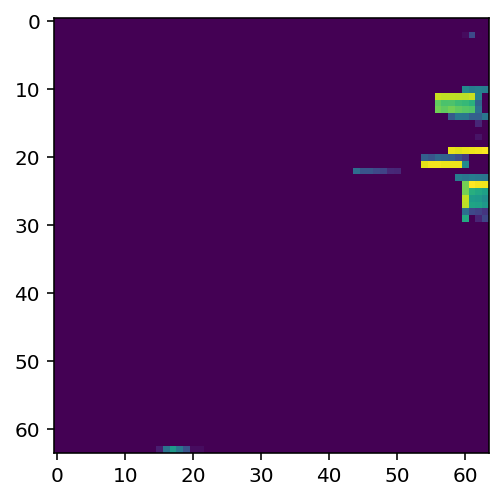

In [48]:
for i in range(128):
    plt.figure()
    plt.imshow(spatial_features[0][i].detach().cpu().numpy())

In [55]:
from second.test_kitti import init_depth_from_feature

if feature.dim() == 3:
    feature = feature.unsqueeze(0)
with torch.no_grad():
    depth = init_depth_from_feature(feature, 512)

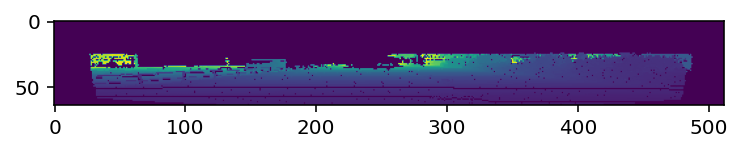

In [33]:
plt.imshow(depth[0].detach().cpu().numpy())

In [ ]:
import torch.nn.functional as F


x = net.feature_extractor.conv1(feature, depth)
x = net.feature_extractor.bn1(x)
x = F.relu(x)

In [ ]:
x.shape

In [ ]:
plt.imshow(x[0][5].detach().cpu().numpy())

In [62]:
depth_ = F.avg_pool2d(depth.float(), 2, padding=1, stride=(2,2)).long()

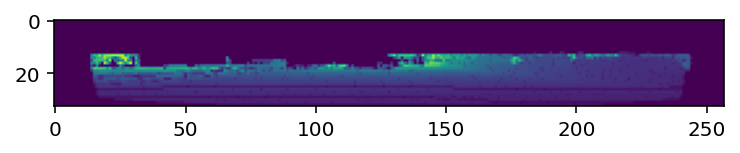

In [63]:
plt.imshow(depth_[0].detach().cpu().numpy())